# Problem Statement

## Context

As an analyst at ABC Estate Wines, we are presented with historical data encompassing the sales of different types of wines throughout the 20th century. These datasets originate from the same company but represent sales figures for distinct wine varieties. Our objective is to delve into the data, analyze trends, patterns, and factors influencing wine sales over the course of the century. By leveraging data analytics and forecasting techniques, we aim to gain actionable insights that can inform strategic decision-making and optimize sales strategies for the future.

## Objective

The primary objective of this project is to analyze and forecast wine sales trends for the 20th century based on historical data provided by ABC Estate Wines. We aim to equip ABC Estate Wines with the necessary insights and foresight to enhance sales performance, capitalize on emerging market opportunities, and maintain a competitive edge in the wine industry.

# Import Necessary Libraries

In [95]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# To display multiple dataframes from one cell
from IPython.display import display

# To perform decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# To build a logistic regression model
from sklearn.linear_model import LinearRegression

#To build exponential smoothening models
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# To visualize ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# To build ARIMA model
from statsmodels.tsa.arima.model import ARIMA

#  To perform date arithmetic, allowing easy calculations and manipulations
from dateutil.relativedelta import relativedelta


# To evaluate the performance of the model
from sklearn.metrics import mean_squared_error

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the Dataset

In [96]:
# loading the rose dataset from drive
from google.colab import drive
drive.mount('/content/drive/')
data = pd.read_csv('/content/drive/My Drive/TSF-Coded-1-Rose.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Understanding the Datasets

In [97]:
# viewing the first 5 rows of the data
data.head()

,YearMonth,Rose
0,1980-01,112.0
1,1980-02,118.0
2,1980-03,129.0
3,1980-04,99.0
4,1980-05,116.0


In [98]:
# Viewing the last 5 rows of the data
data.tail()

,YearMonth,Rose
182,1995-03,45.0
183,1995-04,52.0
184,1995-05,28.0
185,1995-06,40.0
186,1995-07,62.0


In [99]:
# Checking the shape of the data
data.shape

(187, 2)

In [100]:
# Checking the structure and data types of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   YearMonth  187 non-null    object 
 1   Rose       185 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


In [101]:
# Checking the statistical Summary of the data
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
YearMonth,187,187,1980-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rose,185.0,NaN,NaN,NaN,90.394595,39.175344,28.0,63.0,86.0,112.0,267.0


In [102]:
# Checking for missing Values
data.isnull().sum()

,0
YearMonth,0
Rose,2


## Missing Value Treatment

In [103]:
# Filling missing values in 'Rose' column with the mean
data['Rose'] = data['Rose'].fillna(data['Rose'].mean())

# Check for any remaining missing values
print(data.isnull().sum())

YearMonth    0
Rose         0
dtype: int64


In [104]:
data.isnull().sum()

,0
YearMonth,0
Rose,0


Converting yearMonth column into DateTime format for Time Series Analysis

In [105]:
# We are providing inputs to tell pandas that we are trying to work with time series.
data = pd.read_csv('/content/drive/My Drive/TSF-Coded-1-Rose.csv', parse_dates = ['YearMonth'])

In [106]:
# We are providing inputs to tell pandas that we are trying to work with time series and making our time series reference as the index
data = pd.read_csv('/content/drive/My Drive/TSF-Coded-1-Rose.csv', parse_dates = ['YearMonth'], index_col = 'YearMonth')
data.head()

,Rose
YearMonth,
1980-01-01,112.0
1980-02-01,118.0
1980-03-01,129.0
1980-04-01,99.0
1980-05-01,116.0


# Exploratory Data Analysis

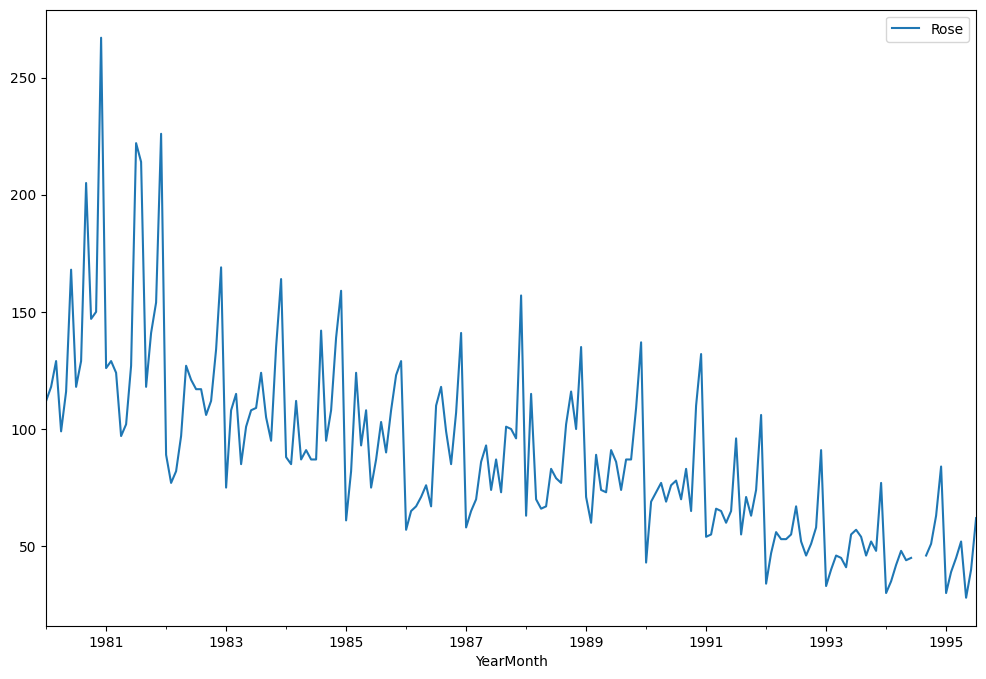

In [107]:
#Increase the figure size
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
data.plot()
plt.show()

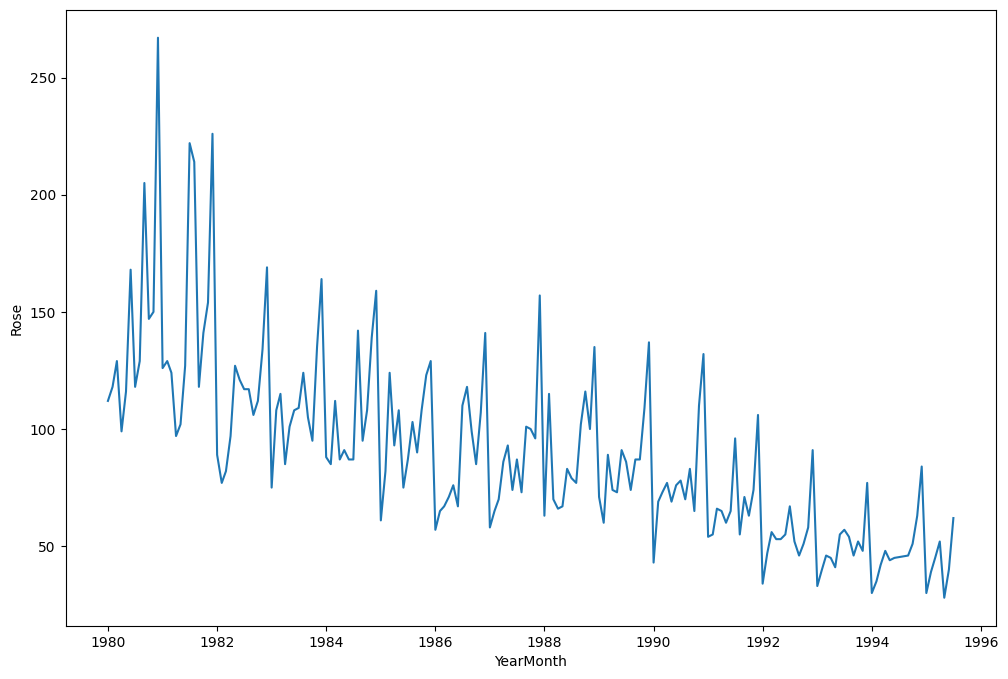

In [108]:
# Trend of the Rose wine sales

plt.figure(figsize=(12, 8))
sns.lineplot(data=data, x=data.index, y='Rose')
plt.show()

In [109]:
#We will resample the data to get values at a month-level from the day-level data by taking the average over the months.

data1 = data.resample('M').mean()
data1.head()

,Rose
YearMonth,
1980-01-31,112.0
1980-02-29,118.0
1980-03-31,129.0
1980-04-30,99.0
1980-05-31,116.0


In [110]:
# Checking the shape of the data
data1.shape

(187, 1)

In [111]:
# Check the Statistics of the data
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Rose,185.0,90.394595,39.175344,28.0,63.0,86.0,112.0,267.0


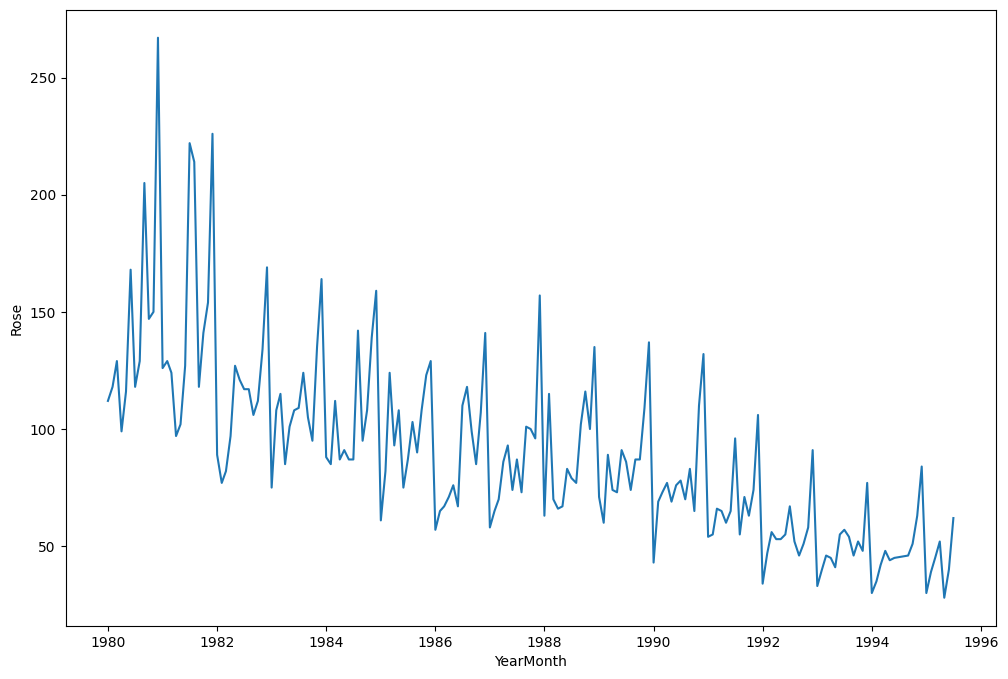

In [112]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=data, x=data.index, y='Rose') # Trend of rose at year level
plt.show()

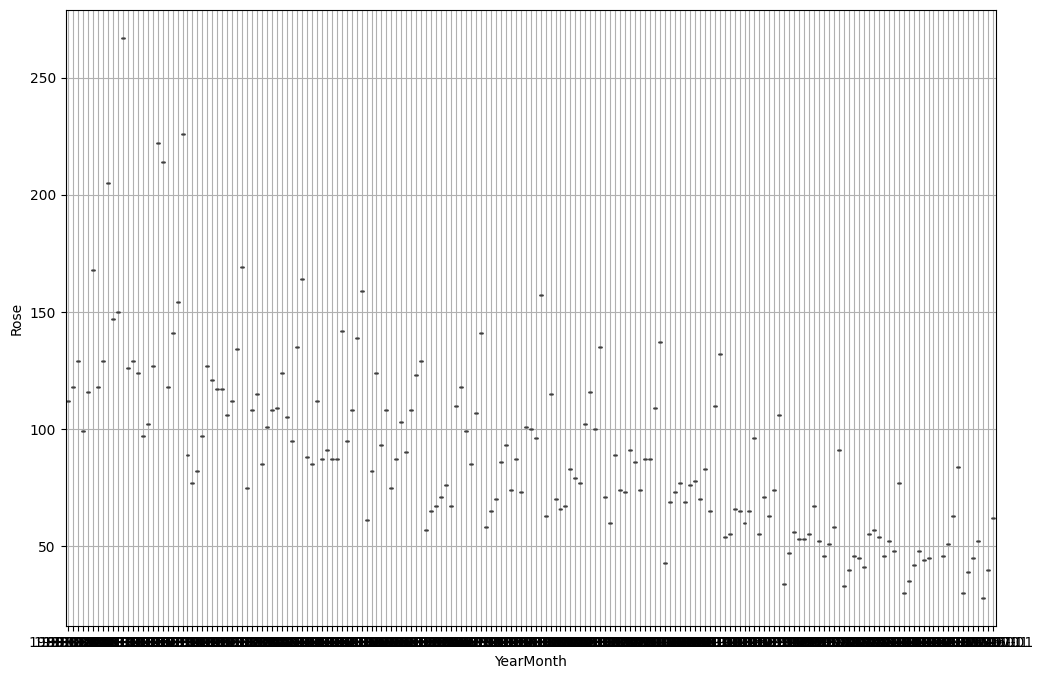

In [113]:
# Boxplot at year level
plt.figure(figsize=(12, 8))
sns.boxplot(x = 'YearMonth',y = 'Rose',data=data)
plt.grid();

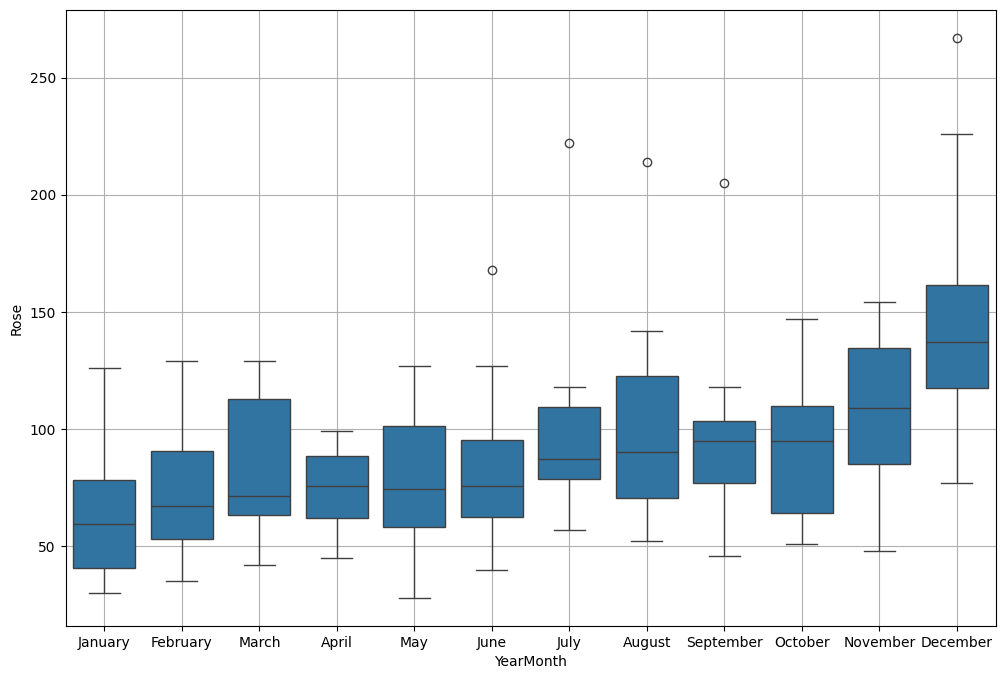

In [114]:
# Boxplot at month level
plt.figure(figsize=(12, 8))
sns.boxplot(x = data.index.month_name(),y = 'Rose',data=data)
plt.grid();

In [115]:
# Pivot table to display monthly Sparkling Sales across years
df = data.copy()
monthly_price_across_years = pd.pivot_table(df, values = 'Rose', columns = df.index.month_name(), index = df.index.year)
monthly_price_across_years

YearMonth,April,August,December,February,January,July,June,March,May,November,October,September
YearMonth,,,,,,,,,,,,
1980,99.0,129.0,267.0,118.0,112.0,118.0,168.0,129.0,116.0,150.0,147.0,205.0
1981,97.0,214.0,226.0,129.0,126.0,222.0,127.0,124.0,102.0,154.0,141.0,118.0
1982,97.0,117.0,169.0,77.0,89.0,117.0,121.0,82.0,127.0,134.0,112.0,106.0
1983,85.0,124.0,164.0,108.0,75.0,109.0,108.0,115.0,101.0,135.0,95.0,105.0
1984,87.0,142.0,159.0,85.0,88.0,87.0,87.0,112.0,91.0,139.0,108.0,95.0
1985,93.0,103.0,129.0,82.0,61.0,87.0,75.0,124.0,108.0,123.0,108.0,90.0
1986,71.0,118.0,141.0,65.0,57.0,110.0,67.0,67.0,76.0,107.0,85.0,99.0
1987,86.0,73.0,157.0,65.0,58.0,87.0,74.0,70.0,93.0,96.0,100.0,101.0
1988,66.0,77.0,135.0,115.0,63.0,79.0,83.0,70.0,67.0,100.0,116.0,102.0


<Figure size 1500x800 with 0 Axes>

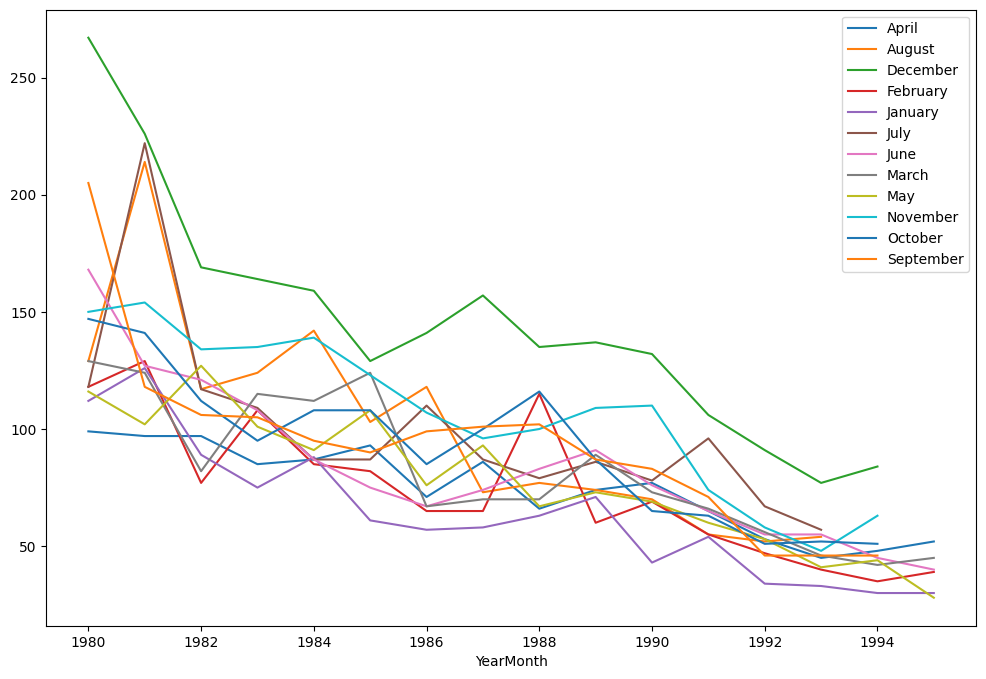

In [116]:
# Plotting trend of months across years
plt.figure(figsize=(15, 8))
monthly_price_across_years.plot(kind='line')
plt.legend(loc='best')
plt.show()

### Decomposition

In [119]:
# Filling missing values in 'Rose' column with the mean
data['Rose'] = data['Rose'].fillna(data['Rose'].mean())

# Check for any remaining missing values
print(data.isnull().sum())

Rose    0
dtype: int64


In [117]:
data.isnull().sum()

,0
Rose,2


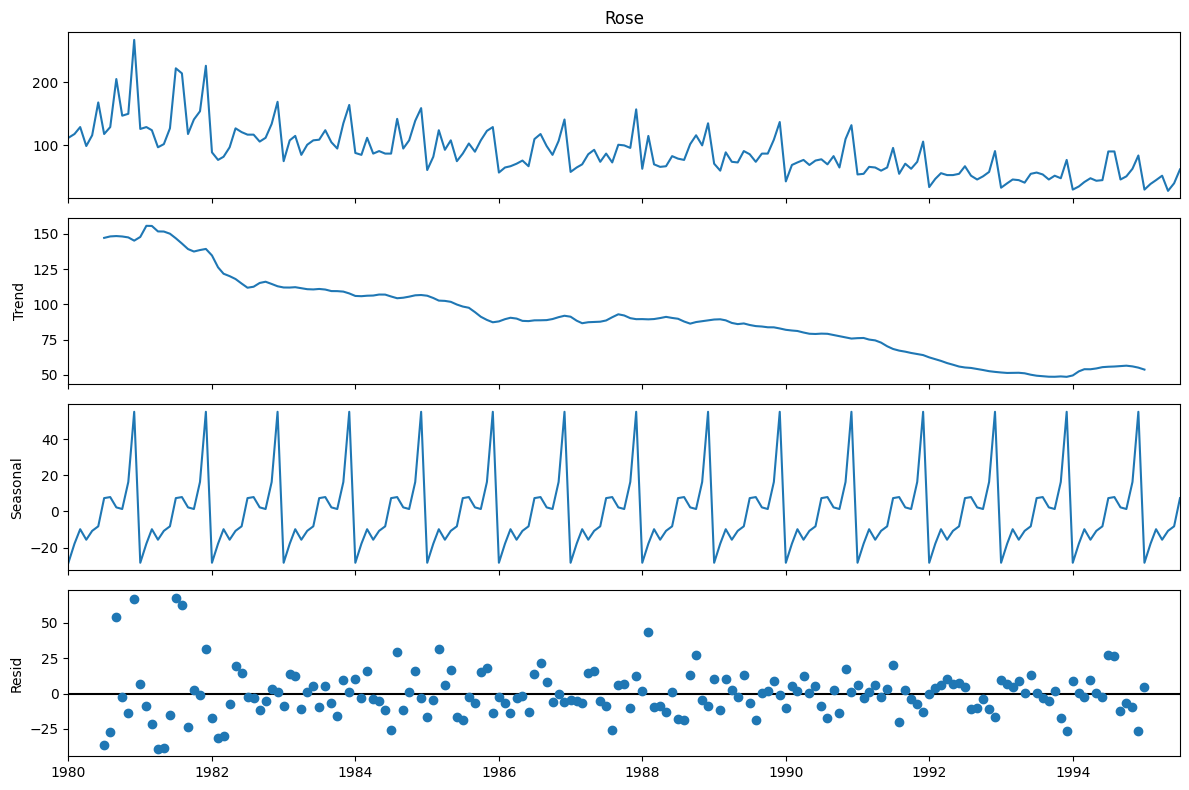

In [120]:
# Decompose the time series additive

df_mul_decompose = seasonal_decompose(data['Rose'], model='additive', period=12)
df_mul_decompose.plot()
plt.show()

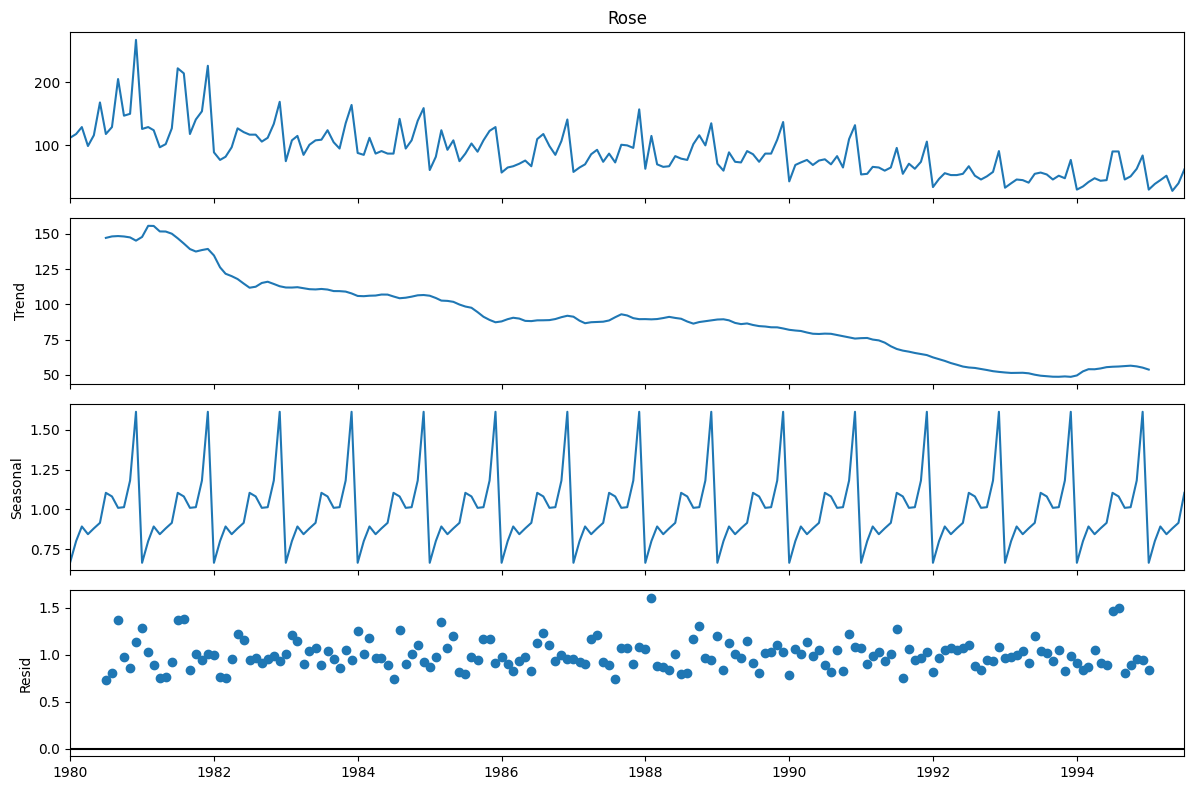

In [121]:
# Decompose the time series multiplicative

df_mul_decompose = seasonal_decompose(data['Rose'], model='multiplicative', period=12)
df_mul_decompose.plot()
plt.show()

# Data Pre-Processing

### Split the data into train and test and plot the training and test data.

In [126]:
# Complete the code to split train set consisting data until 1992 and test set from 1993 onwards
train = data[data.index.year < 1993]
test = data[data.index.year >= 1993]

In [127]:
print('First few rows of Training Data')
display(train.head())
print('Last few rows of Training Data')
display(train.tail())
print('First few rows of Test Data')
display(test.head())
print('Last few rows of Test Data')
display(test.tail())

First few rows of Training Data


,Rose
YearMonth,
1980-01-01,112.0
1980-02-01,118.0
1980-03-01,129.0
1980-04-01,99.0
1980-05-01,116.0


Last few rows of Training Data


,Rose
YearMonth,
1992-08-01,52.0
1992-09-01,46.0
1992-10-01,51.0
1992-11-01,58.0
1992-12-01,91.0


First few rows of Test Data


,Rose
YearMonth,
1993-01-01,33.0
1993-02-01,40.0
1993-03-01,46.0
1993-04-01,45.0
1993-05-01,41.0


Last few rows of Test Data


,Rose
YearMonth,
1995-03-01,45.0
1995-04-01,52.0
1995-05-01,28.0
1995-06-01,40.0
1995-07-01,62.0


In [128]:
#Complete the code to check the shape of train and test sets
print(train.shape)
print(test.shape)

(156, 1)
(31, 1)


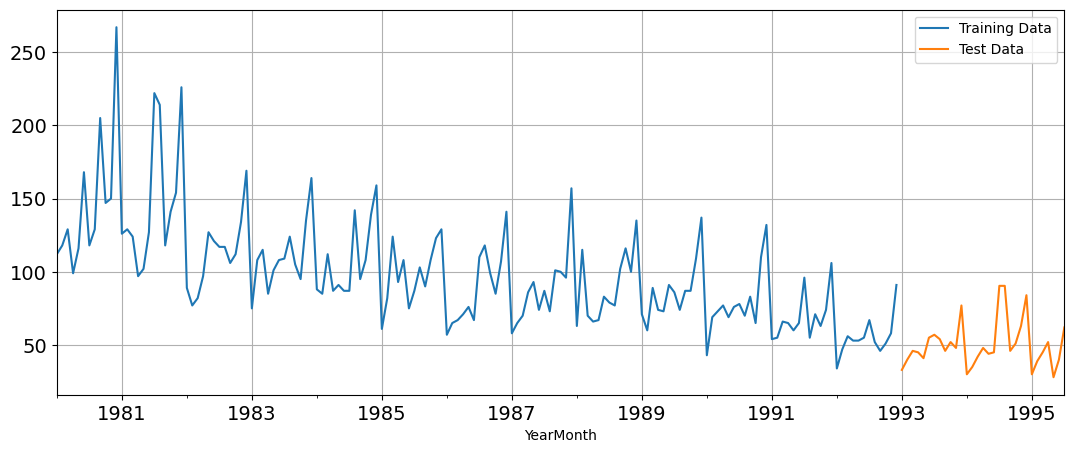

In [129]:
# Trend of Training and Test Data

train['Rose'].plot(figsize=(13,5), fontsize=14)
test['Rose'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

# Model Building - Original Data

### Linear Regression

For this particular linear regression, we are going to regress the 'Sparkling' variable against the order of the occurrence. For this we need to modify our training data before fitting it into a linear regression.

In [130]:
# Generating the numerical time instance order for both the training and test set
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train) for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156]
Test Time instance 
 [156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186]


We see that we have successfully generated the numerical time instance order for both the training and test set. Now we will add these values in the training and test set.

In [131]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

In [132]:
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

print('First few rows of Training Data','\n',LinearRegression_train.head(),'\n')
print('Last few rows of Training Data','\n',LinearRegression_train.tail(),'\n')
print('First few rows of Test Data','\n',LinearRegression_test.head(),'\n')
print('Last few rows of Test Data','\n',LinearRegression_test.tail(),'\n')

First few rows of Training Data 
              Rose  time
YearMonth              
1980-01-01  112.0     1
1980-02-01  118.0     2
1980-03-01  129.0     3
1980-04-01   99.0     4
1980-05-01  116.0     5 

Last few rows of Training Data 
             Rose  time
YearMonth             
1992-08-01  52.0   152
1992-09-01  46.0   153
1992-10-01  51.0   154
1992-11-01  58.0   155
1992-12-01  91.0   156 

First few rows of Test Data 
             Rose  time
YearMonth             
1993-01-01  33.0   156
1993-02-01  40.0   157
1993-03-01  46.0   158
1993-04-01  45.0   159
1993-05-01  41.0   160 

Last few rows of Test Data 
             Rose  time
YearMonth             
1995-03-01  45.0   182
1995-04-01  52.0   183
1995-05-01  28.0   184
1995-06-01  40.0   185
1995-07-01  62.0   186 



Now that our training and test data has been modified, let us go ahead use $\underline{Linear Regression}$ to build the model on the training data and test the model on the test data.

In [133]:
# Defining the linear regression model

lr = LinearRegression()

In [134]:
# Fitting the linear regression model

lr.fit(LinearRegression_train[['time']],LinearRegression_train['Rose'].values)

LinearRegression()

In [135]:
test_predictions_model1 = lr.predict(LinearRegression_test[['time']])  # code to make predictions
LinearRegression_test['RegOnTime'] = test_predictions_model1

train_predictions_model1         = lr.predict(LinearRegression_train[['time']])
LinearRegression_train['RegOnTime'] = train_predictions_model1

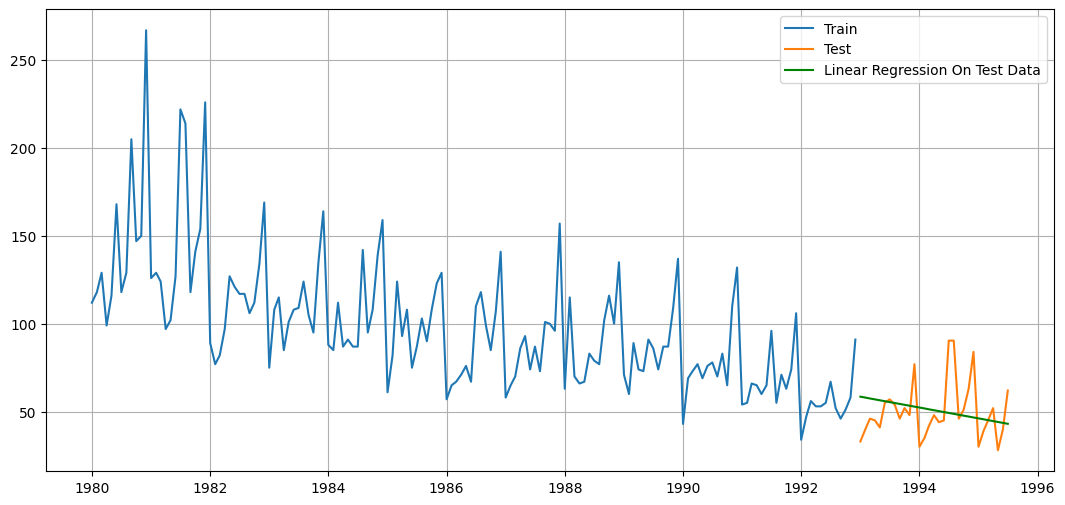

In [136]:
plt.figure(figsize=(13,6))
plt.plot( train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')
plt.plot(LinearRegression_test['RegOnTime'], label='Linear Regression On Test Data', color = 'green')
plt.legend(loc='best')
plt.grid();

In [137]:
## Test Data - RMSE

from sklearn import metrics

rmse_model1_test = metrics.mean_squared_error(test['Rose'],test_predictions_model1) # Complete the code to find the RMSE on test data
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.2f" %(rmse_model1_test))

For RegressionOnTime forecast on the Test Data,  RMSE is 296.57


In [138]:
resultsDf = pd.DataFrame({'Test RMSE': [rmse_model1_test]},index=['Linear Regression'])
resultsDf

,Test RMSE
Linear Regression,296.574259


### Moving Average (MA)

For the moving average model, we are going to calculate rolling means (or moving averages) for different intervals. The best interval can be determined by the maximum accuracy (or the minimum error) over here.
For Moving Average, we are going to average over the entire data.

In [139]:
MovingAverage = data.copy()
MovingAverage.head()

,Rose
YearMonth,
1980-01-01,112.0
1980-02-01,118.0
1980-03-01,129.0
1980-04-01,99.0
1980-05-01,116.0


In [140]:
# Trailing Moving Average

MovingAverage['Trailing_2'] = MovingAverage['Rose'].rolling(2).mean() # 2 point trailing average
MovingAverage['Trailing_4'] = MovingAverage['Rose'].rolling(4).mean() # 4 point trailing average
MovingAverage['Trailing_6'] = MovingAverage['Rose'].rolling(6).mean() # 6 point trailing average
MovingAverage['Trailing_9'] = MovingAverage['Rose'].rolling(9).mean() # 9 point trailing average

MovingAverage.head()

,Rose,Trailing_2,Trailing_4,Trailing_6,Trailing_9
YearMonth,,,,,
1980-01-01,112.0,NaN,NaN,NaN,NaN
1980-02-01,118.0,115.0,NaN,NaN,NaN
1980-03-01,129.0,123.5,NaN,NaN,NaN
1980-04-01,99.0,114.0,114.5,NaN,NaN
1980-05-01,116.0,107.5,115.5,NaN,NaN


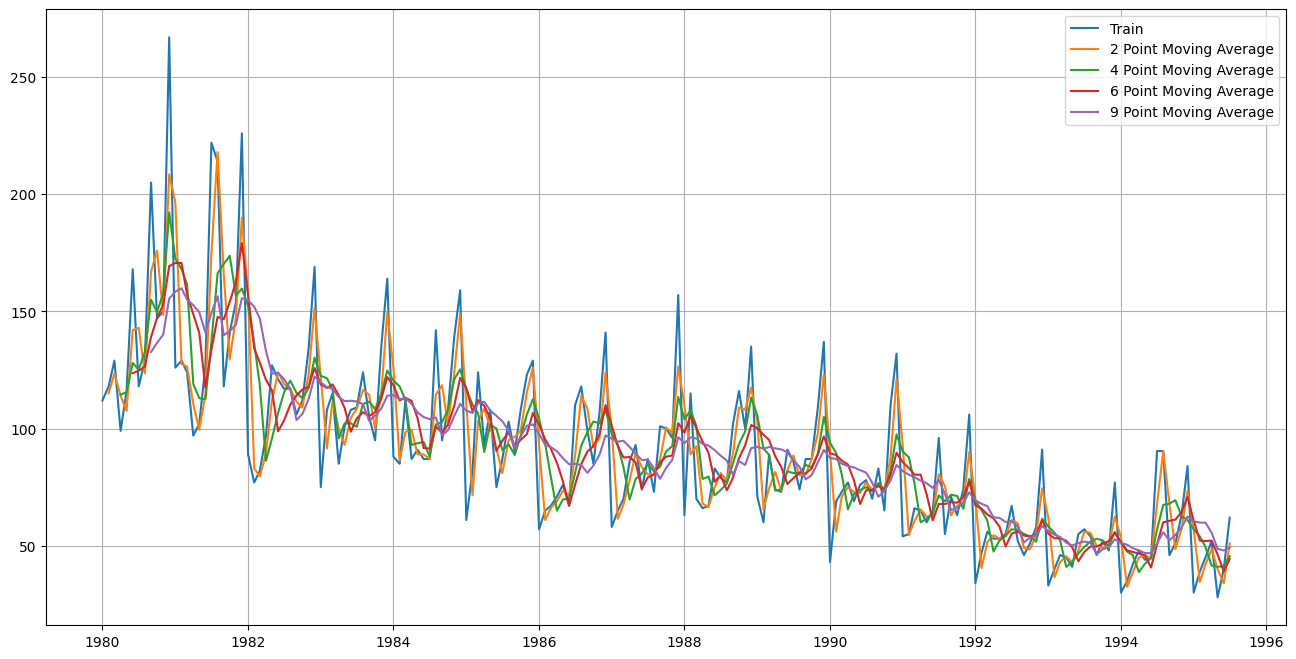

In [141]:
## Plotting on the whole data

plt.figure(figsize=(16,8))
plt.plot(MovingAverage['Rose'], label='Train')
plt.plot(MovingAverage['Trailing_2'], label='2 Point Moving Average') # 2 point moving average
plt.plot(MovingAverage['Trailing_4'], label='4 Point Moving Average') # 4 point moving average
plt.plot(MovingAverage['Trailing_6'], label='6 Point Moving Average') # 6 point moving average
plt.plot(MovingAverage['Trailing_9'], label='9 Point Moving Average') # 9 point moving average

plt.legend(loc = 'best')
plt.grid();

Let us split the data into train and test and plot this Time Series. The window of the moving average is need to be carefully selected as too big a window will result in not having any test set as the whole series might get averaged over.

In [142]:
#Creating train and test set
trailing_MovingAverage_train= MovingAverage[MovingAverage.index.year < 1993]
trailing_MovingAverage_test= MovingAverage[MovingAverage.index.year >= 1993]


In [143]:
## Test Data - RMSE --> 2 point Trailing MA

rmse_model4_test_2 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_2']) #Complete the code to find the RMSE for 2 point moving average
print("For 2 point Moving Average Model forecast on the Testing Data,  RMSE is %3.3f" %(rmse_model4_test_2))

## Test Data - RMSE  --> 4 point Trailing MA

rmse_model4_test_4 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_4']) # RMSE for 4 point moving average
print("For 4 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_4))

## Test Data - RMSE --> 6 point Trailing MA

rmse_model4_test_6 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_6'])
print("For 6 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_6))

## Test Data - RMSE  --> 9 point Trailing MA

rmse_model4_test_9 = metrics.mean_squared_error(test['Rose'],trailing_MovingAverage_test['Trailing_9'])
print("For 9 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_9))

For 2 point Moving Average Model forecast on the Testing Data,  RMSE is 128.190
For 4 point Moving Average Model forecast on the Training Data,  RMSE is 220.595
For 6 point Moving Average Model forecast on the Training Data,  RMSE is 227.388
For 9 point Moving Average Model forecast on the Training Data,  RMSE is 254.211


In [144]:
resultsDf_4 = pd.DataFrame({'Test RMSE': [rmse_model4_test_2,rmse_model4_test_4
                                          ,rmse_model4_test_6,rmse_model4_test_9]}
                           ,index=['2pointTrailingMovingAverage','4pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage','9pointTrailingMovingAverage'])

resultsDf = pd.concat([resultsDf, resultsDf_4])
resultsDf

,Test RMSE
Linear Regression,296.574259
2pointTrailingMovingAverage,128.189913
4pointTrailingMovingAverage,220.594570
6pointTrailingMovingAverage,227.387686
9pointTrailingMovingAverage,254.211371


Before we go on to build the various Exponential Smoothing models, let us plot all the best models and compare the Time Series plots.

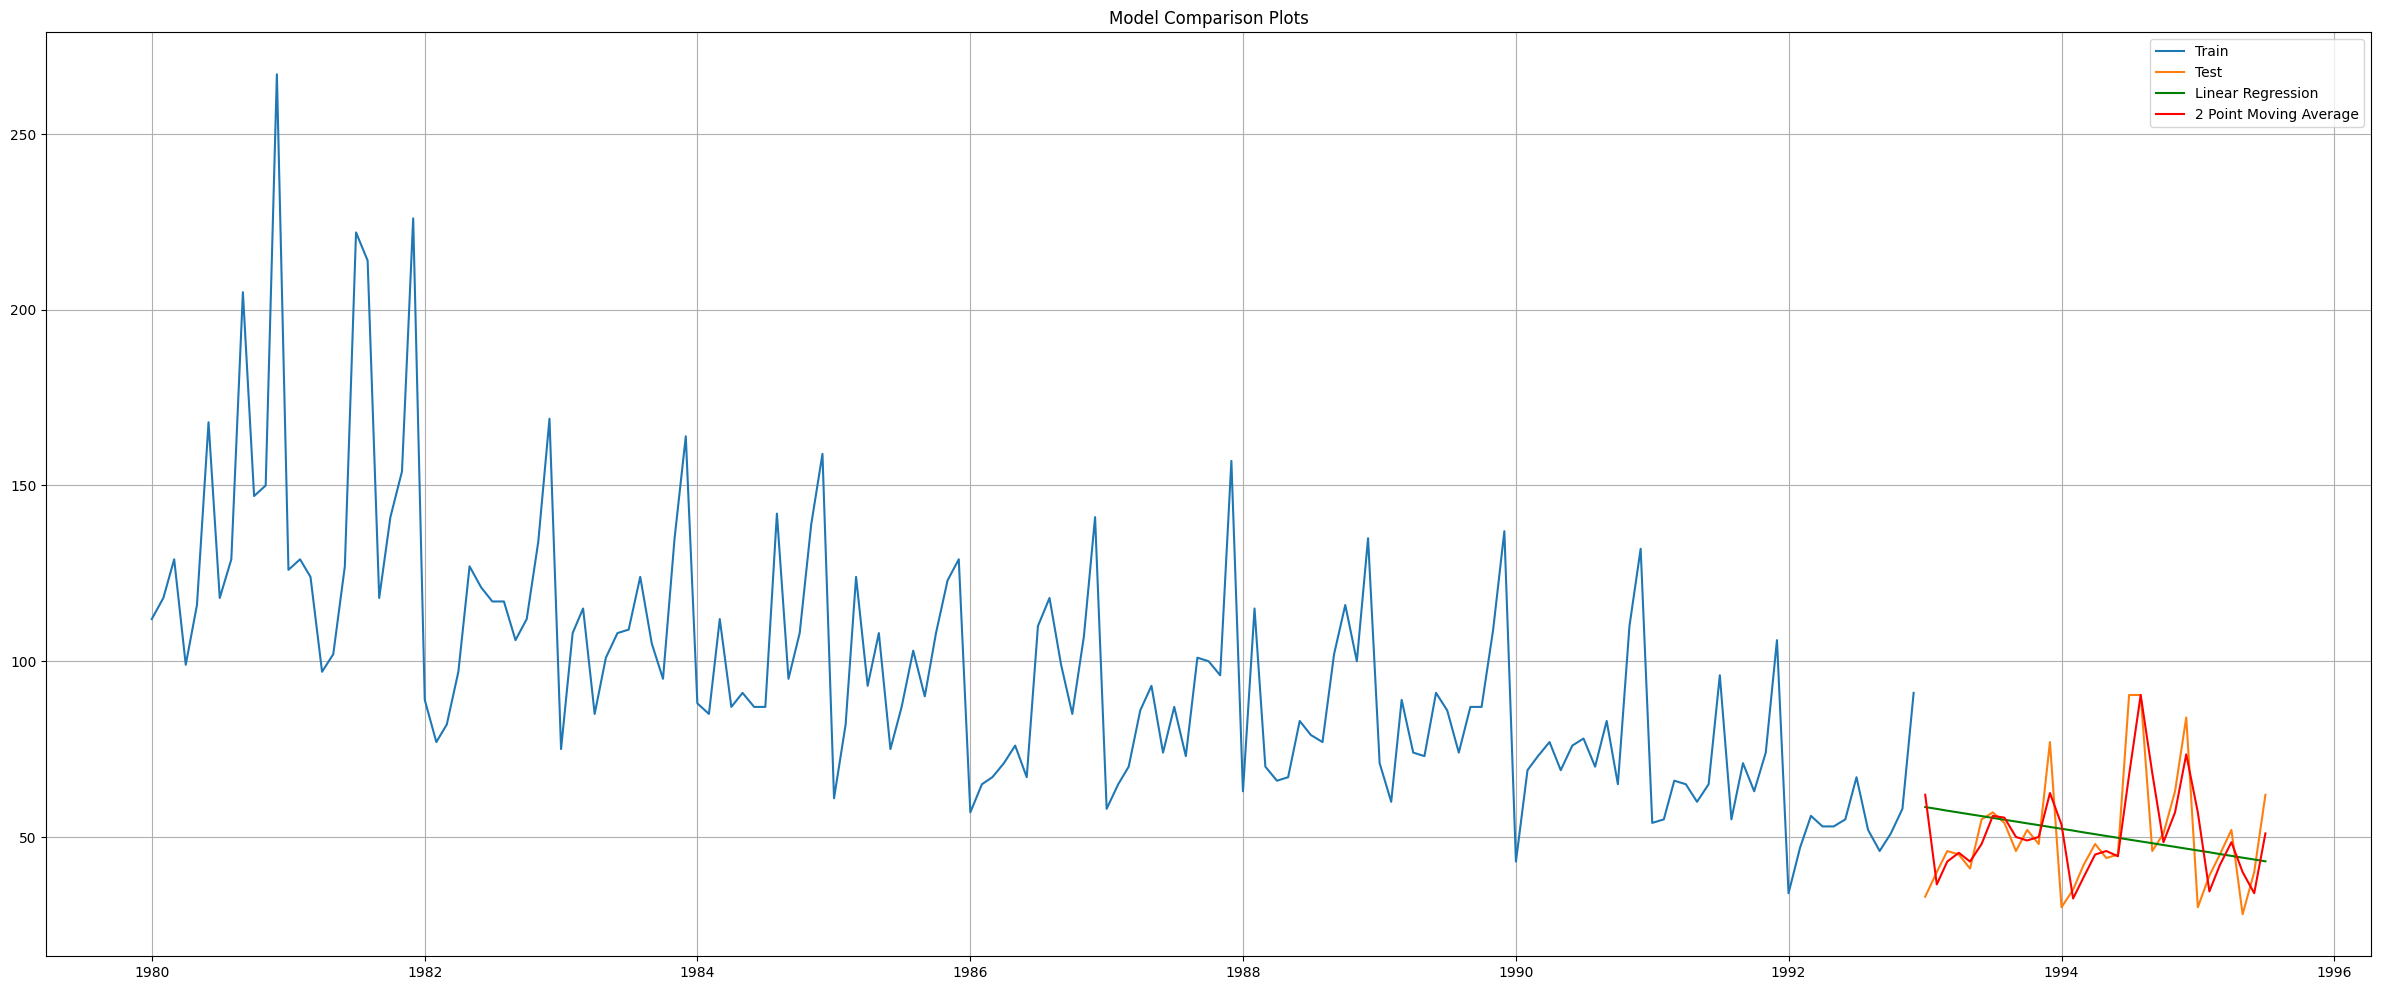

In [146]:
## Plotting on both Training and Test data

plt.figure(figsize=(30,12))
plt.plot(train['Rose'], label='Train')
plt.plot(test['Rose'], label='Test')

# Complete the code to plot the predictions made by the linear regression model
plt.plot(LinearRegression_test['RegOnTime'], label='Linear Regression', color = 'green')

#Complete the code to plot the predictions based on the best moving average model
plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Moving Average', color='red')


plt.legend(loc='best')
plt.title("Model Comparison Plots")
plt.grid();

### Simple Exponential Smoothening Models

In [147]:
SES_train = train.copy()
SES_test = test.copy()

In [148]:
model_SES = SimpleExpSmoothing(SES_train['Rose']) # Define the simple exponential smoothening model

In [149]:
# model_SES = '__________________________'(SES_train['_______']) #Define the simple exponential smoothening model

In [150]:
model_SES_autofit = model_SES.fit(optimized=True)   #Fit the simple exponential smoothening model

In [151]:
# model_SES_autofit = '_______'.'___'(optimized=True)   #Fit the simple exponential smoothening model

In [152]:
model_SES_autofit.params

{'smoothing_level': 0.12948030833097124,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [154]:
SES_test['predict'] = model_SES_autofit.forecast(steps=len(test))   #Forecast the model
SES_test.head()

,Rose,predict
YearMonth,,
1993-01-01,33.0,62.459601
1993-02-01,40.0,62.459601
1993-03-01,46.0,62.459601
1993-04-01,45.0,62.459601
1993-05-01,41.0,62.459601


In [155]:
# SES_test['predict'] = '____________________'.'______________'(steps=len(test))   #Forecast the model

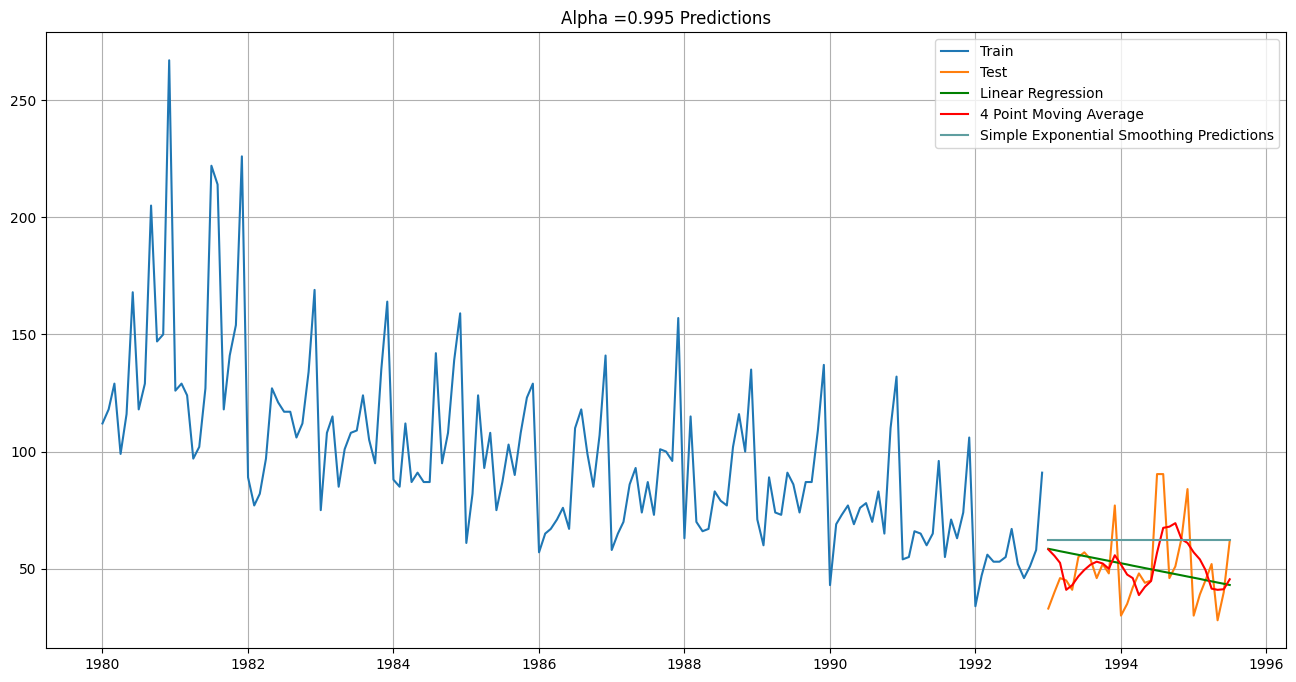

In [156]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(SES_train['Rose'], label='Train')
plt.plot(SES_test['Rose'], label='Test')

# Complete the code to plot the predictions made by the linear regression model
plt.plot(LinearRegression_test['RegOnTime'], label='Linear Regression', color = 'green')

#Complete the code to plot the predictions based on the best moving average model
plt.plot(trailing_MovingAverage_test['Trailing_4'], label='4 Point Moving Average', color='red')

#Complete the code to plot the predictions based on the simple exponential smoothening model
plt.plot(SES_test['predict'], label='Simple Exponential Smoothing Predictions', color='cadetblue')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha =0.995 Predictions');

Model Evaluation for  𝛼
  = 0.995 : Simple Exponential Smoothing

In [157]:
## Test Data
#Complete the code to find the RMSE of simple exponential smoothening model
rmse_model5_test_1 = metrics.mean_squared_error(test['Rose'],SES_test['predict'])
print("For Alpha =0.995 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is %3.3f" %(rmse_model5_test_1))


For Alpha =0.995 Simple Exponential Smoothing Model forecast on the Test Data, RMSE is 405.965


In [158]:
resultsDf_5 = pd.DataFrame({'Test RMSE': [rmse_model5_test_1]},index=['Alpha=0.995,SimpleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_5])
resultsDf

,Test RMSE
Linear Regression,296.574259
2pointTrailingMovingAverage,128.189913
4pointTrailingMovingAverage,220.594570
6pointTrailingMovingAverage,227.387686
9pointTrailingMovingAverage,254.211371
"Alpha=0.995,SimpleExponentialSmoothing",405.965108


### Double Exponential Smoothening (Holt's Model)

Two parameters  𝛼
  and  𝛽
  are estimated in this model. Level and Trend are accounted for in this model.

In [69]:
DES_train = train.copy()
DES_test = test.copy()

In [70]:
# prompt: model_DES = '______________'  #Define the double exponential smoothening model

#model_DES = Holt(DES_train['Sparkling'])  # Define the double exponential smoothing model
model_DES = Holt(DES_train,initialization_method='estimated')

In [71]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_7 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_7

,Alpha Values,Beta Values,Train RMSE,Test RMSE


In [72]:
# prompt: for i in np.arange(0.3,1.1,0.1):
#     for j in np.arange(0.3,1.1,0.1):
#         model_DES_alpha_i_j = '______'.'______'(smoothing_level=i,smoothing_trend=j,optimized=False,use_brute=True) #fit the model
#         DES_train['predict',i,j] = model_DES_alpha_i_j.fittedvalues
#         DES_test['predict',i,j] = model_DES_alpha_i_j.'_______'(steps=37)  #Forecast the model
#         rmse_model6_train = '___________'('________________','________________',squared=False) #Find the RMSE on train data
#         rmse_model6_test = '_____________'('_______________','________________',squared=False)    #Find teh RMSE on test data
#         resultsDf_7 = resultsDf_7.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse_model6_train
#                                           ,'Test RMSE':rmse_model6_test}, ignore_index=True)

import pandas as pd
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error

for i in np.arange(0.3, 1.1, 0.1):
    for j in np.arange(0.3, 1.1, 0.1):
        model_DES_alpha_i_j = Holt(DES_train['Rose'], initialization_method='estimated').fit(smoothing_level=i, smoothing_trend=j, optimized=False, use_brute=True) #fit the model
        DES_train['predict'+str(i)+str(j)] = model_DES_alpha_i_j.fittedvalues
        DES_test['predict'+str(i)+str(j)] = model_DES_alpha_i_j.forecast(steps=37)  #Forecast the model
        rmse_model6_train = mean_squared_error(DES_train['Rose'], DES_train['predict'+str(i)+str(j)]) #Find the RMSE on train data
        rmse_model6_test = mean_squared_error(test['Rose'],DES_test['predict'+str(i)+str(j)])    #Find teh RMSE on test data
        #resultsDf_7 = resultsDf_7.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse_model6_train
                                         # ,'Test RMSE':rmse_model6_test})

In [73]:
# Replace the append with pd.concat

resultsDf_7 = pd.concat([resultsDf_7, pd.DataFrame([{'Alpha Values': i, 'Beta Values': j, 'Train RMSE': rmse_model6_train, 'Test RMSE': rmse_model6_test}])], ignore_index=True)

In [74]:
resultsDf_7.sort_values(by=['Test RMSE']).head()

,Alpha Values,Beta Values,Train RMSE,Test RMSE
0,1.0,1.0,3753.551212,409696.775695


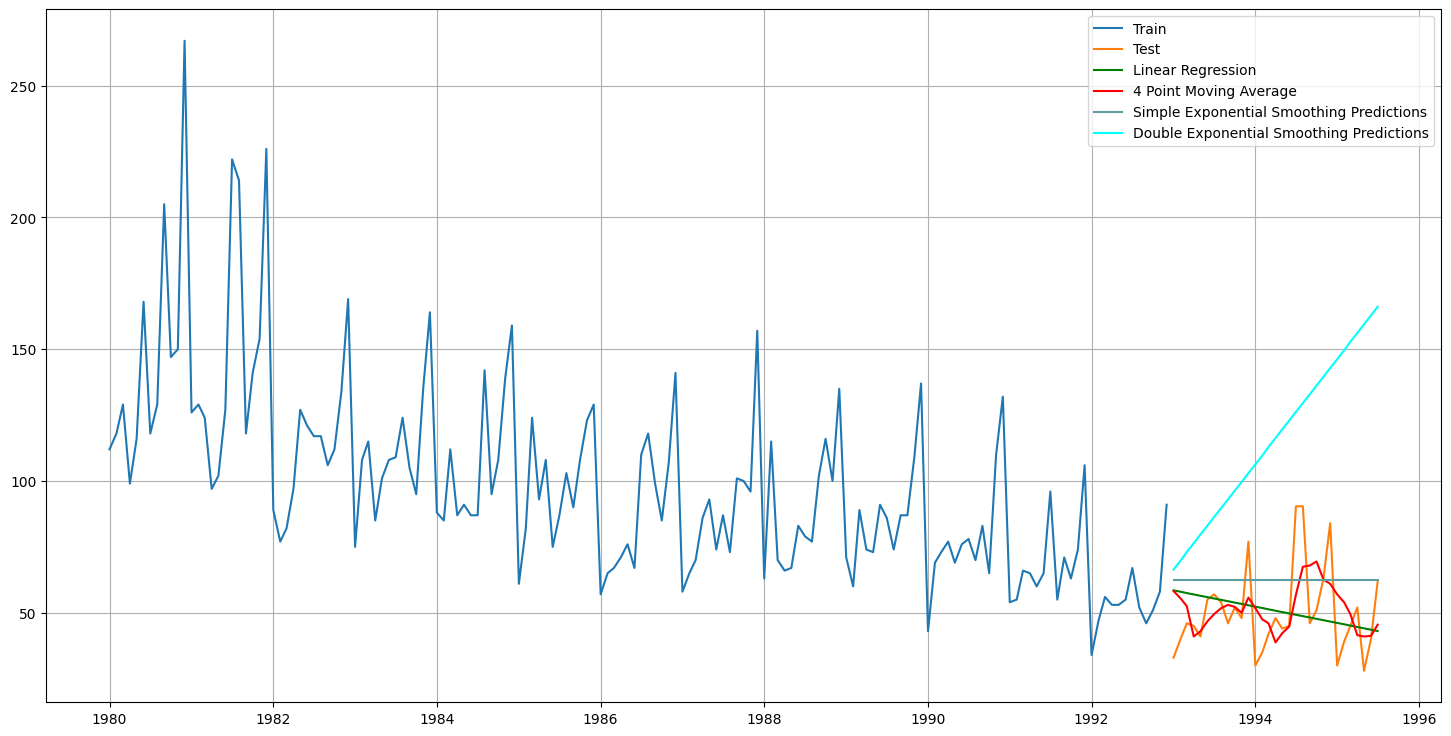

In [75]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(DES_train['Rose'], label='Train')
plt.plot(DES_test['Rose'], label='Test')

# Complete the code to plot the predictions made by the linear regression model
plt.plot(LinearRegression_test['RegOnTime'], label='Linear Regression', color = 'green')

#Complete the code to plot the predictions based on the best moving average model
plt.plot(trailing_MovingAverage_test['Trailing_4'], label='4 Point Moving Average', color='red')

#Complete the code to plot the predictions based on the simple exponential smoothening model
plt.plot(SES_test['predict'], label='Simple Exponential Smoothing Predictions', color='cadetblue')

#Complete the code to plot the predictions based on the double exponential smoothening model
plt.plot(DES_test['predict0.30.3'], label='Double Exponential Smoothing Predictions', color='cyan')


plt.legend(loc='best')
plt.grid();

In [76]:
resultsDf_7_1 = pd.DataFrame({'Test RMSE': [resultsDf_7.sort_values(by=['Test RMSE']).values[0][3]]}
                           ,index=['Alpha=0.9,Beta=0.3,DoubleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_7_1])
resultsDf

,Test RMSE
Linear Regression,296.574259
2pointTrailingMovingAverage,128.189913
4pointTrailingMovingAverage,220.594570
6pointTrailingMovingAverage,227.387686
9pointTrailingMovingAverage,254.211371
"Alpha=0.995,SimpleExponentialSmoothing",405.965108
"Alpha=0.9,Beta=0.3,DoubleExponentialSmoothing",409696.775695


### Triple Exponential Smoothing (Holt - Winter's Model)

Three parameters  𝛼
 ,  𝛽
  and  𝛾
  are estimated in this model. Level, Trend and Seasonality are accounted for in this model.

In [77]:
TES_train = train.copy()
TES_test = test.copy()

In [78]:
model_TES = ExponentialSmoothing(TES_train['Rose'],trend='additive',seasonal='additive',seasonal_periods=12)  #Define the triple exponential smoothening model

In [79]:
# model_TES = '_________________'('_____________',trend='___________',seasonal='____________')  #Define the triple exponential smoothening model

In [80]:
# model_TES_autofit = model_TES."______"   #Fit the triple exponential smoothening model

In [81]:
model_TES_autofit = model_TES.fit()   #Fit the triple exponential smoothening model

In [82]:
model_TES_autofit.params

{'smoothing_level': 0.09509083303858493,
 'smoothing_trend': 7.769745611839437e-05,
 'smoothing_seasonal': 0.002521115063116996,
 'damping_trend': nan,
 'initial_level': 146.9050470558056,
 'initial_trend': -0.6151877914985002,
 'initial_seasons': array([-30.02031629, -18.32351441,  -9.8563535 , -18.9937688 ,
        -11.8086869 ,  -6.56456019,   5.38204   ,   6.36920981,
          3.94321345,   2.25447711,  19.12137587,  60.09787995]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [83]:
## Prediction on the test data

TES_test['auto_predict'] = model_TES_autofit.forecast(steps=len(test))  #Forecast thetriple exponential smoothening model
TES_test.head()

,Rose,auto_predict
YearMonth,,
1993-01-01,33.0,20.292930
1993-02-01,40.0,31.374936
1993-03-01,46.0,39.225909
1993-04-01,45.0,29.474811
1993-05-01,41.0,36.043157


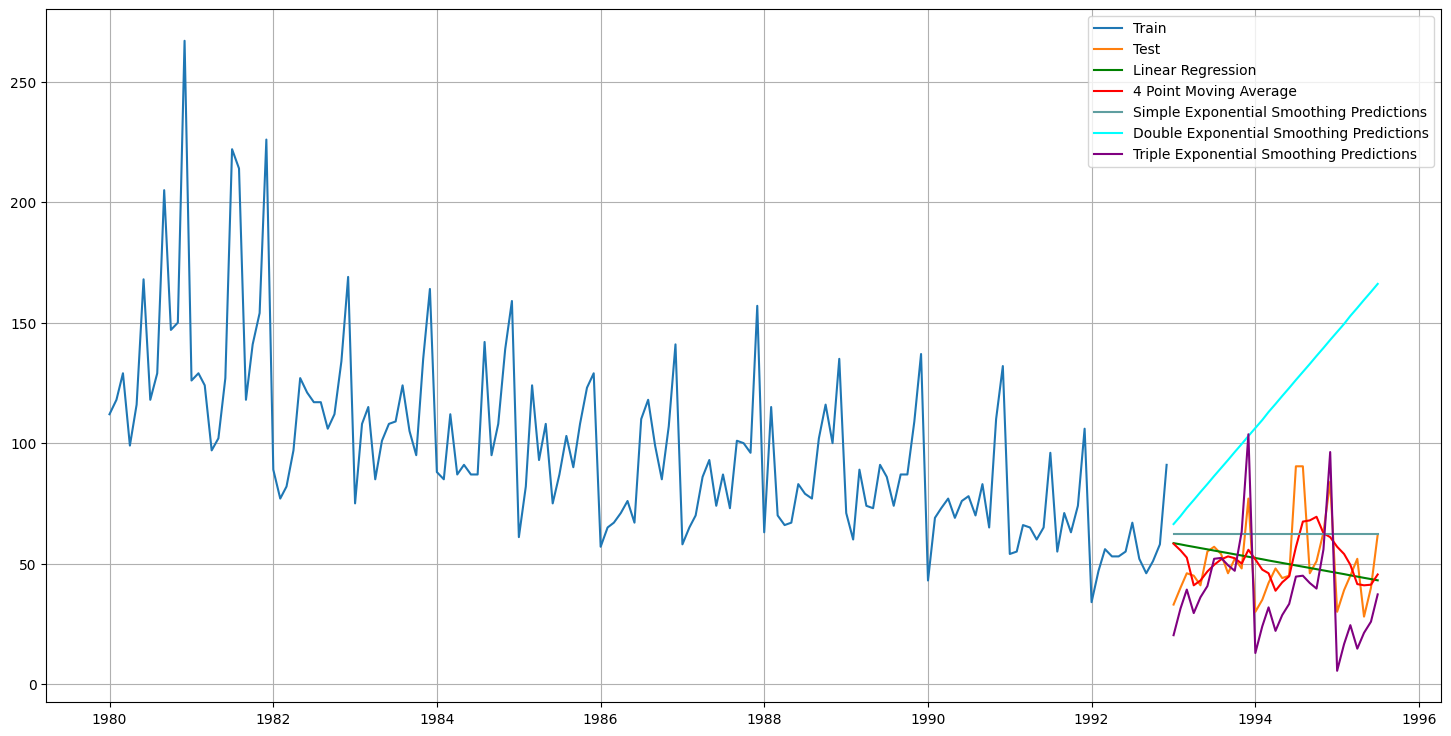

In [84]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(TES_train['Rose'], label='Train')
plt.plot(TES_test['Rose'], label='Test')

# Complete the code to plot the predictions made by the linear regression model
plt.plot(LinearRegression_test['RegOnTime'], label='Linear Regression', color = 'green')

#Complete the code to plot the predictions based on the best moving average model
plt.plot(trailing_MovingAverage_test['Trailing_4'], label='4 Point Moving Average', color='red')

#Complete the code to plot the predictions based on the simple exponential smoothening model
plt.plot(SES_test['predict'], label='Simple Exponential Smoothing Predictions', color='cadetblue')

#Complete the code to plot the predictions based on the double exponential smoothening model
plt.plot(DES_test['predict0.30.3'], label='Double Exponential Smoothing Predictions', color='cyan')

#Complete the code to plot the predictions based on the triple exponential smoothening model
plt.plot(TES_test['auto_predict'], label='Triple Exponential Smoothing Predictions', color='purple')


plt.legend(loc='best')
plt.grid();

In [86]:
# prompt: ## Test Data
# rmse_model6_test_1 = '____________________'(TES_test['________'],TES_test['___________'],squared=False) #Find the RMSE on test data
# print("For Alpha=0.676,Beta=0.088,Gamma=0.323, Triple Exponential Smoothing Model forecast on the Test Data,  RMSE is %3.3f" %(rmse_model6_test_1))

rmse_model6_test_1 = metrics.mean_squared_error(TES_test['Rose'],TES_test['auto_predict']) #Find the RMSE on test data
print("For Alpha=0.676,Beta=0.088,Gamma=0.323, Triple Exponential Smoothing Model forecast on the Test Data,  RMSE is %3.3f" %(rmse_model6_test_1))

For Alpha=0.676,Beta=0.088,Gamma=0.323, Triple Exponential Smoothing Model forecast on the Test Data,  RMSE is 374.064


In [87]:
resultsDf_8_1 = pd.DataFrame({'Test RMSE': [rmse_model6_test_1]}
                           ,index=['Alpha=0.676,Beta=0.088,Gamma=0.323,TripleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_8_1])
resultsDf

,Test RMSE
Linear Regression,296.574259
2pointTrailingMovingAverage,128.189913
4pointTrailingMovingAverage,220.594570
6pointTrailingMovingAverage,227.387686
9pointTrailingMovingAverage,254.211371
"Alpha=0.995,SimpleExponentialSmoothing",405.965108
"Alpha=0.9,Beta=0.3,DoubleExponentialSmoothing",409696.775695
"Alpha=0.676,Beta=0.088,Gamma=0.323,TripleExponentialSmoothing",374.063568


In [88]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_8_2 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_8_2

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE


In [89]:
# prompt: for i in np.arange(0.3,1.1,0.1):
#     for j in np.arange(0.3,1.1,0.1):
#         for k in np.arange(0.3,1.1,0.1):
#             model_TES_alpha_i_j_k = model_TES.'_________'('_______','_______','______________',optimized=False,use_brute='___') #Fit the model
#             TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
#             TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.'___________'(steps=37)    #Forecast the model
#             rmse_model8_train = '___________________'(TES_train['____'],TES_train['___________'],squared=False) #Find the RMSE on train data
#             rmse_model8_test = '_______________'(TES_test['_______'],TES_test['___________'],squared=False) #Find the RMSE on test data
#             resultsDf_8_2 = resultsDf_8_2.append({'Alpha Values':i,'Beta Values':j,'Gamma Values':k,
#                                                   'Train RMSE':rmse_model8_train,'Test RMSE':rmse_model8_test}
#                                                  , ignore_index=True)

resultsDf_8_2 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],'Test RMSE': []})
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            model_TES_alpha_i_j_k = model_TES.fit(smoothing_level=i, smoothing_trend=j, smoothing_seasonal=k, optimized=False, use_brute=True) #Fit the model
            TES_train[f'predict_{i}_{j}_{k}'] = model_TES_alpha_i_j_k.fittedvalues
            TES_test[f'predict_{i}_{j}_{k}'] = model_TES_alpha_i_j_k.forecast(steps=37)    #Forecast the model
            rmse_model8_train = mean_squared_error(TES_train['Rose'],TES_train[f'predict_{i}_{j}_{k}']) #Find the RMSE on train data
            rmse_model8_test = mean_squared_error(TES_test['Rose'],TES_test[f'predict_{i}_{j}_{k}']) #Find the RMSE on test data
            resultsDf_8_2 = pd.concat([resultsDf_8_2, pd.DataFrame([{'Alpha Values':i,'Beta Values':j,'Gamma Values':k,
                                                  'Train RMSE':rmse_model8_train,'Test RMSE':rmse_model8_test}])], ignore_index=True)

In [90]:
resultsDf_8_2.sort_values(by=['Test RMSE']).head()

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Test RMSE
24,0.3,0.6,0.3,720.249795,205.066163
73,0.4,0.4,0.4,700.286916,424.477108
130,0.5,0.3,0.5,779.045403,435.752867
195,0.6,0.3,0.6,1054.297531,619.872539
81,0.4,0.5,0.4,870.915116,720.815054


In [91]:
list(TES_test.columns)

['Rose',
 'auto_predict',
 'predict_0.3_0.3_0.3',
 'predict_0.3_0.3_0.4',
 'predict_0.3_0.3_0.5',
 'predict_0.3_0.3_0.6000000000000001',
 'predict_0.3_0.3_0.7000000000000002',
 'predict_0.3_0.3_0.8000000000000003',
 'predict_0.3_0.3_0.9000000000000001',
 'predict_0.3_0.3_1.0000000000000002',
 'predict_0.3_0.4_0.3',
 'predict_0.3_0.4_0.4',
 'predict_0.3_0.4_0.5',
 'predict_0.3_0.4_0.6000000000000001',
 'predict_0.3_0.4_0.7000000000000002',
 'predict_0.3_0.4_0.8000000000000003',
 'predict_0.3_0.4_0.9000000000000001',
 'predict_0.3_0.4_1.0000000000000002',
 'predict_0.3_0.5_0.3',
 'predict_0.3_0.5_0.4',
 'predict_0.3_0.5_0.5',
 'predict_0.3_0.5_0.6000000000000001',
 'predict_0.3_0.5_0.7000000000000002',
 'predict_0.3_0.5_0.8000000000000003',
 'predict_0.3_0.5_0.9000000000000001',
 'predict_0.3_0.5_1.0000000000000002',
 'predict_0.3_0.6000000000000001_0.3',
 'predict_0.3_0.6000000000000001_0.4',
 'predict_0.3_0.6000000000000001_0.5',
 'predict_0.3_0.6000000000000001_0.6000000000000001',
 '

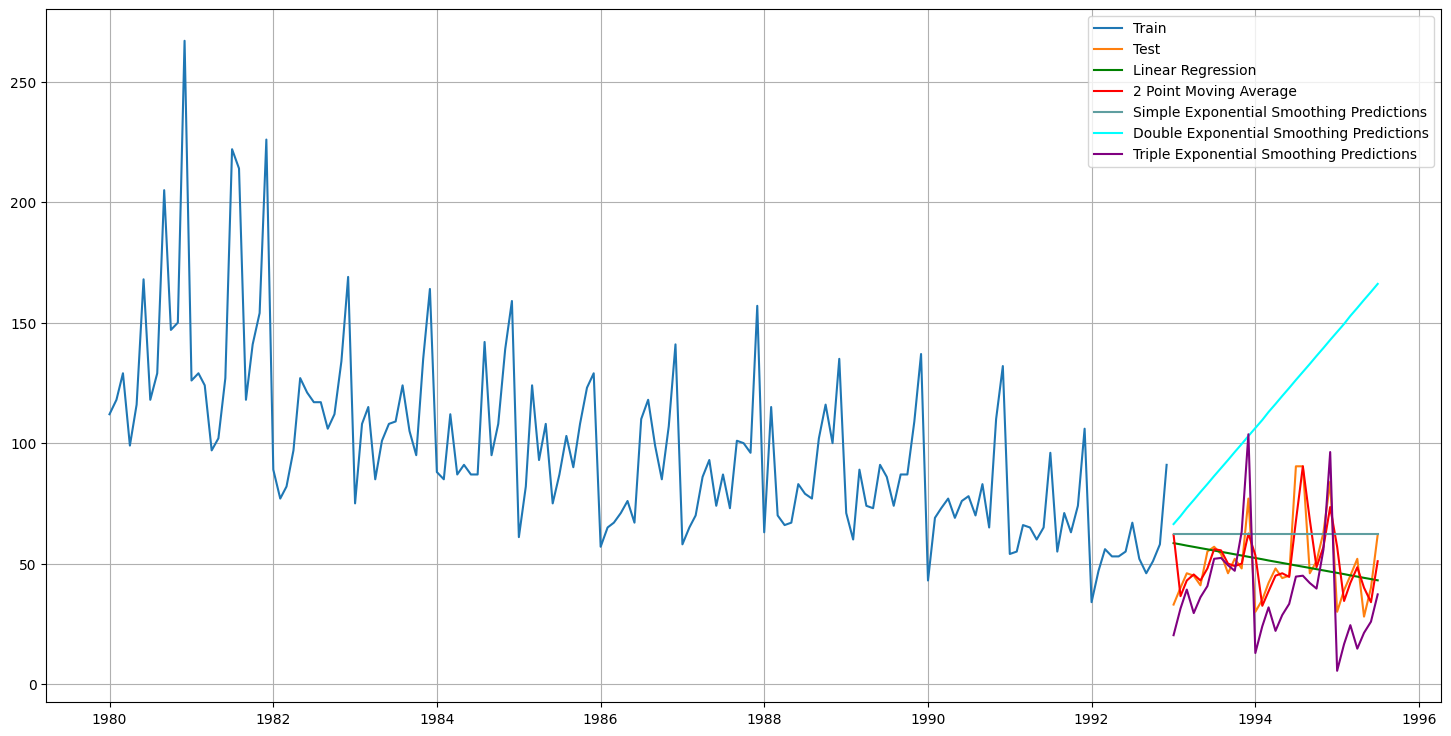

In [93]:
## Plotting on both the Training and Test data using brute force alpha, beta and gamma determination

plt.figure(figsize=(18,9))
plt.plot(TES_train['Rose'], label='Train')
plt.plot(TES_test['Rose'], label='Test')


# Complete the code to plot the predictions made by the linear regression model
plt.plot(LinearRegression_test['RegOnTime'], label='Linear Regression', color = 'green')

#Complete the code to plot the predictions based on the best moving average model
plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Moving Average', color='red')

#Complete the code to plot the predictions based on the simple exponential smoothening model
plt.plot(SES_test['predict'], label='Simple Exponential Smoothing Predictions', color='cadetblue')

#Complete the code to plot the predictions based on the double exponential smoothening model
plt.plot(DES_test['predict0.30.3'], label='Double Exponential Smoothing Predictions', color='cyan')

#Complete the code to plot the predictions based on the triple exponential smoothening model
plt.plot(TES_test['auto_predict'], label='Triple Exponential Smoothing Predictions', color='purple')


plt.legend(loc='best')
plt.grid();

In [94]:
resultsDf_8_3 = pd.DataFrame({'Test RMSE': [resultsDf_8_2.sort_values(by=['Test RMSE']).values[0][4]]}
                           ,index=['Alpha=0.8,Beta=0.5,Gamma=0.5,TripleExponentialSmoothing'])

results_Df = pd.concat([resultsDf, resultsDf_8_3])
results_Df

,Test RMSE
Linear Regression,296.574259
2pointTrailingMovingAverage,128.189913
4pointTrailingMovingAverage,220.594570
6pointTrailingMovingAverage,227.387686
9pointTrailingMovingAverage,254.211371
"Alpha=0.995,SimpleExponentialSmoothing",405.965108
"Alpha=0.9,Beta=0.3,DoubleExponentialSmoothing",409696.775695
"Alpha=0.676,Beta=0.088,Gamma=0.323,TripleExponentialSmoothing",374.063568
"Alpha=0.8,Beta=0.5,Gamma=0.5,TripleExponentialSmoothing",205.066163


In [ ]:
print('Sorted by RMSE values on the Test Data:','\n',)
results_Df.sort_values(by=['Test RMSE'])

Sorted by RMSE values on the Test Data: 



,Test RMSE
"Alpha=0.676,Beta=0.088,Gamma=0.323,TripleExponentialSmoothing",1.078671e+05
"Alpha=0.8,Beta=0.5,Gamma=0.5,TripleExponentialSmoothing",1.422019e+05
2pointTrailingMovingAverage,7.452916e+05
4pointTrailingMovingAverage,1.418502e+06
6pointTrailingMovingAverage,1.656642e+06
"Alpha=0.995,SimpleExponentialSmoothing",1.667686e+06
9pointTrailingMovingAverage,1.764540e+06
Linear Regression,1.803630e+06
"Alpha=0.9,Beta=0.3,DoubleExponentialSmoothing",1.635052e+09


# Check for stationarity of the whole Time Series data.

In [160]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean() #determining the rolling mean
    rolstd = timeseries.rolling(window=7).std()   #determining the rolling standard deviation

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

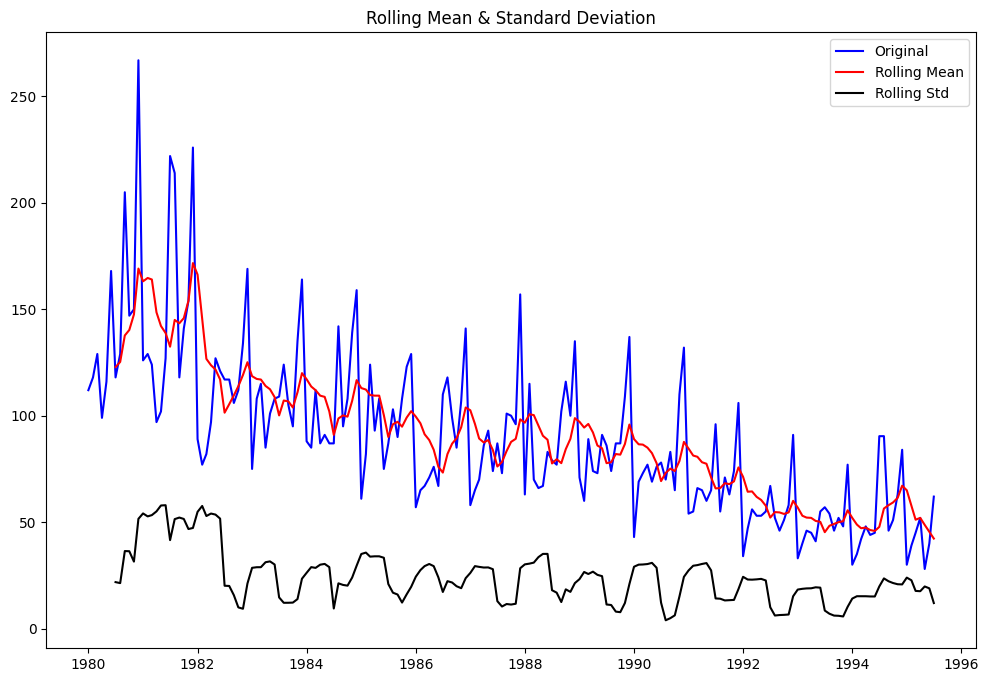

Results of Dickey-Fuller Test:
Test Statistic                  -1.933803
p-value                          0.316330
#Lags Used                      13.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64 



In [161]:
# prompt: test_stationarity('____________')     #Complete the code to test stationarity on the data

test_stationarity(data['Rose'])

# Model Building - Stationary Data

### Auto ARIMA Model

In [164]:
## The following loop helps us in getting a combination of different parameters of p and q in the range of 0 and 2
## We have kept the value of d as 1 as we need to take a difference of the series to make it stationary.

import itertools
p = q = range(0, 3)
d= [1] #complete the code to ensure stationarity
pdq = list(itertools.product(p, d, q))
print('Some parameter combinations for the Model...')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Some parameter combinations for the Model...
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)


In [165]:
# d = [1] #complete the code to ensure stationarity

In [166]:
# Creating an empty Dataframe with column names only
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

,param,AIC


In [167]:
for param in pdq:
    ARIMA_model = ARIMA(train['Rose'], order=param).fit()  #Fit the ARIMA model
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))   #Complete the code to find the AIC values
    ARIMA_AIC = pd.concat([ARIMA_AIC, pd.DataFrame({'param': [param], 'AIC': [ARIMA_model.aic]})], ignore_index=True)

ARIMA(0, 1, 0) - AIC:1563.9607518084563
ARIMA(0, 1, 1) - AIC:1501.0427661730591
ARIMA(0, 1, 2) - AIC:1498.3505767679824
ARIMA(1, 1, 0) - AIC:1544.6812341542188
ARIMA(1, 1, 1) - AIC:1499.3673542674383
ARIMA(1, 1, 2) - AIC:1497.6631798823091
ARIMA(2, 1, 0) - AIC:1521.176884799488
ARIMA(2, 1, 1) - AIC:1499.8258232335806
ARIMA(2, 1, 2) - AIC:1499.6439922162272


In [168]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

ARIMA_AIC.sort_values(by='AIC',ascending=True)

,param,AIC
5,"(1, 1, 2)",1497.663180
2,"(0, 1, 2)",1498.350577
4,"(1, 1, 1)",1499.367354
8,"(2, 1, 2)",1499.643992
7,"(2, 1, 1)",1499.825823
1,"(0, 1, 1)",1501.042766
6,"(2, 1, 0)",1521.176885
3,"(1, 1, 0)",1544.681234
0,"(0, 1, 0)",1563.960752


In [169]:
auto_ARIMA = ARIMA(train['Rose'], order=(2,1,2))  #Build the ARIMA model based on the best AIC values

results_auto_ARIMA = auto_ARIMA.fit()  #Fit the auto ARIMA model
print(results_auto_ARIMA.summary())   #Print the summary result

                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  156
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -744.822
Date:                Sun, 05 Jan 2025   AIC                           1499.644
Time:                        17:46:03   BIC                           1514.861
Sample:                    01-01-1980   HQIC                          1505.825
                         - 12-01-1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4831      0.370     -1.306      0.191      -1.208       0.242
ar.L2         -0.0140      0.139     -0.101      0.920      -0.286       0.258
ma.L1         -0.2281      0.362     -0.629      0.5

Predict on the Test Set using this model and evaluate the model.

In [172]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(test))  #Forecast using the auto ARIMA
predicted_auto_ARIMA

,predicted_mean
1993-01-01,69.134896
1993-02-01,60.921110
1993-03-01,65.195087
1993-04-01,63.245349
1993-05-01,64.127422
1993-06-01,63.728593
1993-07-01,63.908916
1993-08-01,63.827386
1993-09-01,63.864248
1993-10-01,63.847582


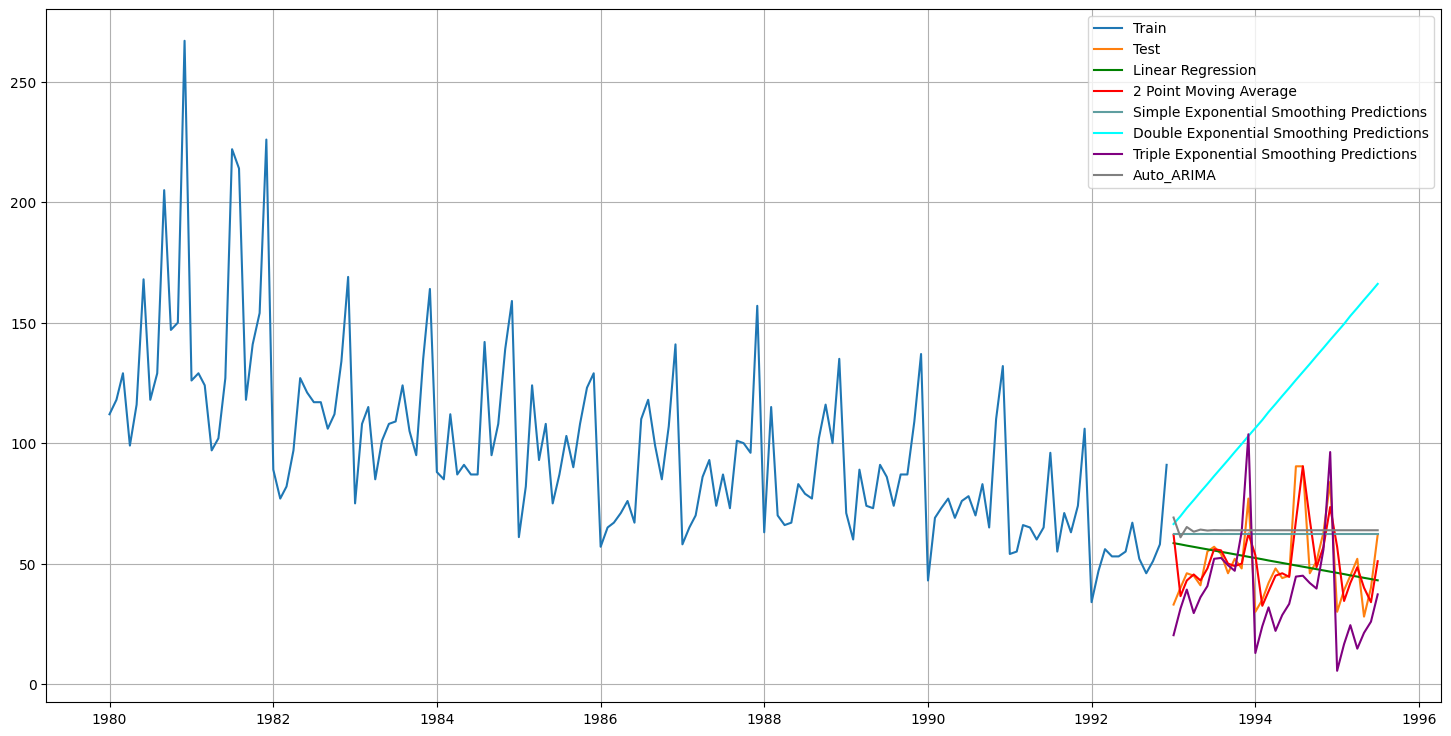

In [173]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(TES_train['Rose'], label='Train')
plt.plot(TES_test['Rose'], label='Test')

# Complete the code to plot the predictions made by the linear regression model
plt.plot(LinearRegression_test['RegOnTime'], label='Linear Regression', color = 'green')

#Complete the code to plot the predictions based on the best moving average model
plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Moving Average', color='red')

#Complete the code to plot the predictions based on the simple exponential smoothening model
plt.plot(SES_test['predict'], label='Simple Exponential Smoothing Predictions', color='cadetblue')

#Complete the code to plot the predictions based on the double exponential smoothening model
plt.plot(DES_test['predict0.30.3'], label='Double Exponential Smoothing Predictions', color='cyan')

#Complete the code to plot the predictions based on the triple exponential smoothening model
plt.plot(TES_test['auto_predict'], label='Triple Exponential Smoothing Predictions', color='purple')

#Complete the code to plot the predictions based on the Auto ARIMA model
plt.plot(predicted_auto_ARIMA, label='Auto_ARIMA', color='gray')

plt.legend(loc='best')
plt.grid();

In [174]:
rmse = mean_squared_error(test['Rose'], predicted_auto_ARIMA)  #Find the RMSE on test data
rmse

450.2489201973321

In [175]:
resultsDf = pd.DataFrame({'RMSE': [rmse]}, index=['Auto_ARIMA'])
resultsDf

,RMSE
Auto_ARIMA,450.24892


### ARIMA Model

In [ ]:
## The following loop helps us in getting a combination of different parameters of p and q in the range of 0 and 2
## We have kept the value of d as 1 as we need to take a difference of the series to make it stationary.

import itertools
p = range(0, 3)  #Define the range of AR values based on the ACF & PACF plots
q = range(0, 3)   #Define the range of AR values based on the ACF & PACF plots
d= [1]   #Define the value to make the data stationary
pdq = list(itertools.product(p, d, q))
print('Some parameter combinations for the Model...')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Some parameter combinations for the Model...
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)


In [ ]:
for param in pdq:
    ARIMA_model = ARIMA(train['Sparkling_diff'], order=param).fit() #Fit the ARIMA model
    print('ARIMA{} - AIC:{}'.format(param, ARIMA_model.aic))  #Complete the code to find teh AIC values
    ARIMA_AIC = pd.concat([ARIMA_AIC, pd.DataFrame({'param': [param], 'AIC': [ARIMA_model.aic]})], ignore_index=True)

ARIMA(0, 1, 0) - AIC:2801.198981016615
ARIMA(0, 1, 1) - AIC:2676.8195202259885
ARIMA(0, 1, 2) - AIC:2669.576661533585
ARIMA(1, 1, 0) - AIC:2759.9877599032607
ARIMA(1, 1, 1) - AIC:2674.0721737204103
ARIMA(1, 1, 2) - AIC:2639.6777086661596
ARIMA(2, 1, 0) - AIC:2735.7146174144673
ARIMA(2, 1, 1) - AIC:2668.067318262088
ARIMA(2, 1, 2) - AIC:2636.6213951760737


In [ ]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

ARIMA_AIC.sort_values(by='AIC',ascending=True)

,param,AIC
8,"(2, 1, 2)",2636.621395
17,"(2, 1, 2)",2636.621395
5,"(1, 1, 2)",2639.677709
14,"(1, 1, 2)",2639.677709
7,"(2, 1, 1)",2668.067318
16,"(2, 1, 1)",2668.067318
2,"(0, 1, 2)",2669.576662
11,"(0, 1, 2)",2669.576662
4,"(1, 1, 1)",2674.072174
13,"(1, 1, 1)",2674.072174


In [178]:
ARIMA_model1 = ARIMA(train['Rose'], order=((2,1,2)))   #Build the ARIMA model based on the best params

results_ARIMA = ARIMA_model1.fit()  #Fit the ARIMA model

print(results_ARIMA.summary())  #Print the summary result

                               SARIMAX Results                                
Dep. Variable:                   Rose   No. Observations:                  156
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -744.822
Date:                Sun, 05 Jan 2025   AIC                           1499.644
Time:                        17:55:51   BIC                           1514.861
Sample:                    01-01-1980   HQIC                          1505.825
                         - 12-01-1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4831      0.370     -1.306      0.191      -1.208       0.242
ar.L2         -0.0140      0.139     -0.101      0.920      -0.286       0.258
ma.L1         -0.2281      0.362     -0.629      0.5

In [181]:
predicted_ARIMA = results_ARIMA.predict(steps=len(test))  #Forecast the ARIMA model
predicted_ARIMA

,predicted_mean
1980-01-01,0.000000
1980-02-01,111.945246
1980-03-01,115.834015
1980-04-01,121.222506
1980-05-01,109.431744
...,...
1992-08-01,65.502519
1992-09-01,60.660620
1992-10-01,60.639317
1992-11-01,59.756225


In [183]:
rmse1= mean_squared_error(test['Rose'], predicted_ARIMA) #Find the RMSE on test data
rmse1

450.2489201973321

In [182]:
predicted_ARIMA = results_ARIMA.predict(start=test.index[0], end=test.index[-1])  # Forecast using the ARIMA model

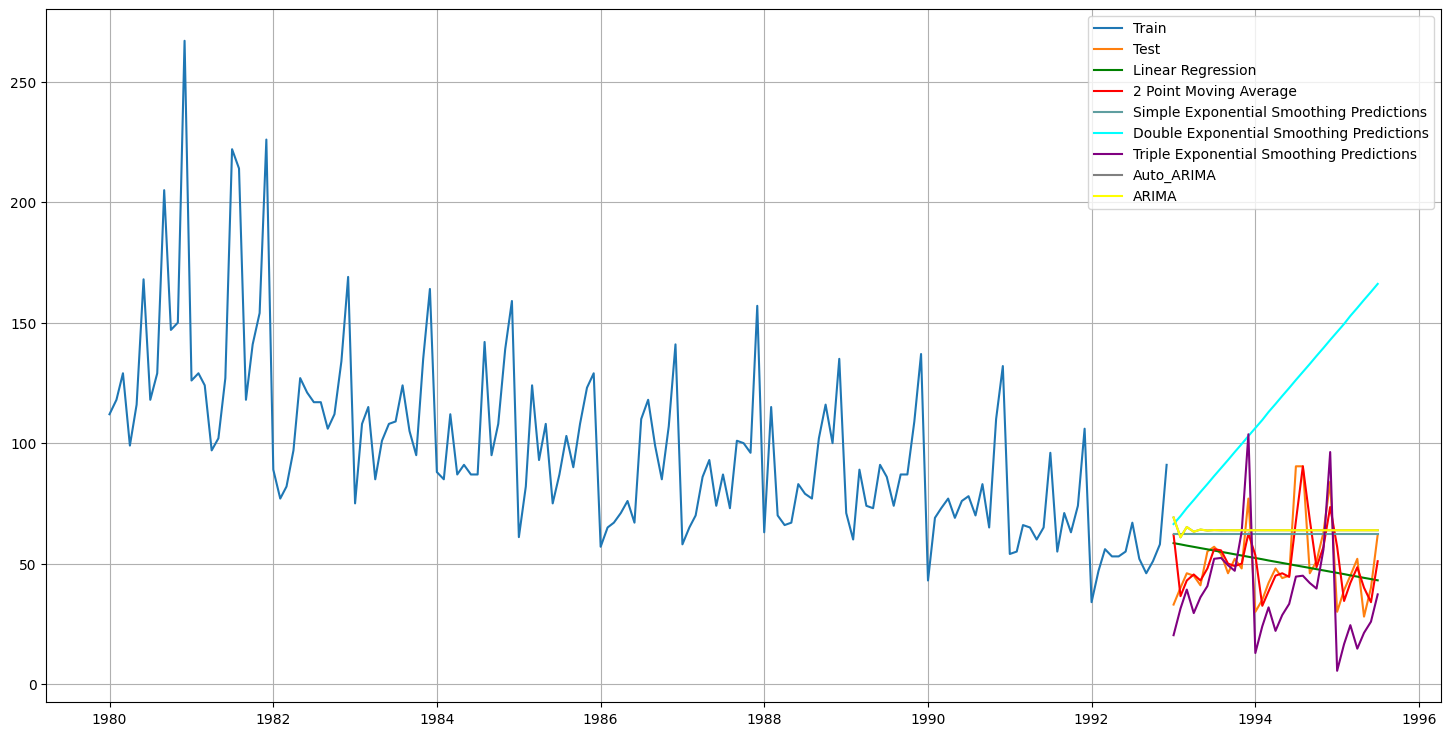

In [185]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(TES_train['Rose'], label='Train')
plt.plot(TES_test['Rose'], label='Test')


# Complete the code to plot the predictions made by the linear regression model
plt.plot(LinearRegression_test['RegOnTime'], label='Linear Regression', color = 'green')

#Complete the code to plot the predictions based on the best moving average model
plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Moving Average', color='red')

#Complete the code to plot the predictions based on the simple exponential smoothening model
plt.plot(SES_test['predict'], label='Simple Exponential Smoothing Predictions', color='cadetblue')

#Complete the code to plot the predictions based on the double exponential smoothening model
plt.plot(DES_test['predict0.30.3'], label='Double Exponential Smoothing Predictions', color='cyan')

#Complete the code to plot the predictions based on the triple exponential smoothening model
plt.plot(TES_test['auto_predict'], label='Triple Exponential Smoothing Predictions', color='purple')

#Complete the code to plot the predictions based on the Auto ARIMA model
plt.plot(predicted_auto_ARIMA, label='Auto_ARIMA', color='gray')

plt.plot(predicted_ARIMA, label='ARIMA', color='yellow')

plt.legend(loc='best')
plt.grid();

In [186]:
# prompt: temp_resultsDf = pd.DataFrame({'RMSE': [rmse]}
#                            ,index=['_________'])
# resultsDf= pd.concat([resultsDf,temp_resultsDf])
# resultsDf

temp_resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['ARIMA'])
resultsDf= pd.concat([resultsDf,temp_resultsDf])
resultsDf

,RMSE
Auto_ARIMA,450.24892
ARIMA,450.24892


In [187]:
results_Df

,Test RMSE
Linear Regression,296.574259
2pointTrailingMovingAverage,128.189913
4pointTrailingMovingAverage,220.594570
6pointTrailingMovingAverage,227.387686
9pointTrailingMovingAverage,254.211371
"Alpha=0.995,SimpleExponentialSmoothing",405.965108
"Alpha=0.9,Beta=0.3,DoubleExponentialSmoothing",409696.775695
"Alpha=0.676,Beta=0.088,Gamma=0.323,TripleExponentialSmoothing",374.063568
"Alpha=0.8,Beta=0.5,Gamma=0.5,TripleExponentialSmoothing",205.066163


# Compare the Performance of the model & Forecast

In [188]:
results_Df.rename(columns={'Test RMSE':'RMSE'},inplace=True)
result = pd.concat([results_Df, resultsDf])
result.sort_values(by='RMSE')
result

,RMSE
Linear Regression,296.574259
2pointTrailingMovingAverage,128.189913
4pointTrailingMovingAverage,220.594570
6pointTrailingMovingAverage,227.387686
9pointTrailingMovingAverage,254.211371
"Alpha=0.995,SimpleExponentialSmoothing",405.965108
"Alpha=0.9,Beta=0.3,DoubleExponentialSmoothing",409696.775695
"Alpha=0.676,Beta=0.088,Gamma=0.323,TripleExponentialSmoothing",374.063568
"Alpha=0.8,Beta=0.5,Gamma=0.5,TripleExponentialSmoothing",205.066163
Auto_ARIMA,450.248920


2-point Trailing Moving Average has the lowest RMSE of 128.189913, making it the best-performing model among the tested approaches.

Linear Regression has a higher RMSE of 296.574259, indicating less accuracy compared to moving average models.

Other moving average models (4-point, 6-point, and 9-point) perform moderately well, but their RMSE values (220.549570, 227.387686, and 254.211371, respectively) are higher than the 2-point Trailing Moving Average.

Simple Exponential Smoothing (Alpha = 0.995) has an RMSE of 405.965108, which is less accurate than all moving average models.

Double Exponential Smoothing (Alpha = 0.9, Beta = 0.3) performs the worst, with the highest RMSE of 40996.775695, likely due to poor parameter tuning or unsuitability for the dataset.

Triple Exponential Smoothing with Alpha = 0.8, Beta = 0.5, and Gamma = 0.5 performs relatively well, with an RMSE of 205.066163, but it is still not as effective as the 2-point Trailing Moving Average.


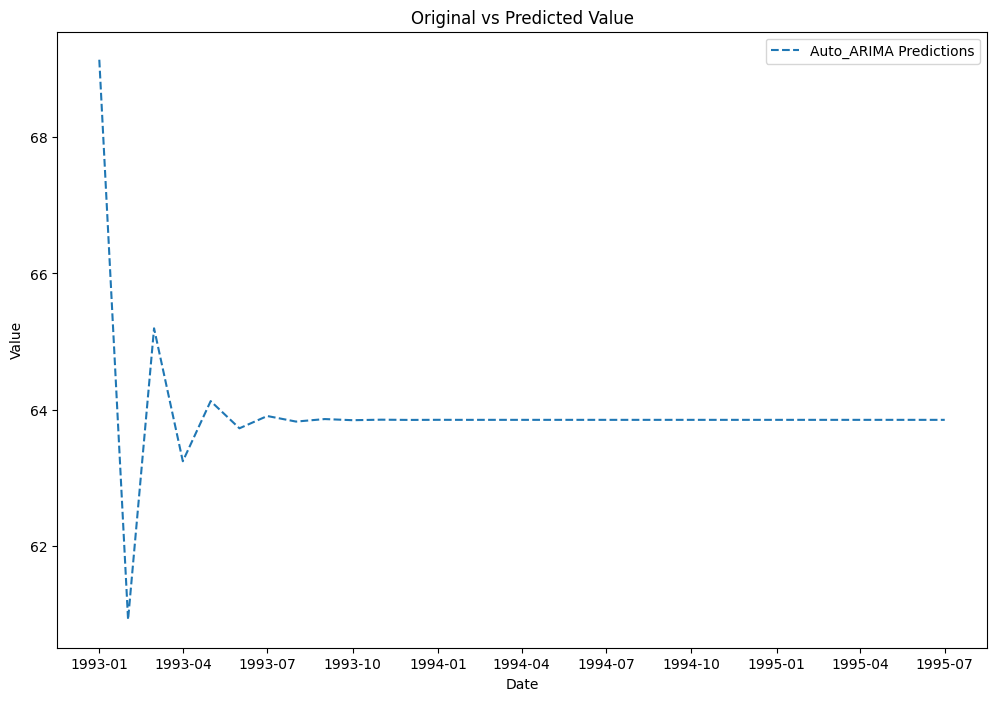

In [190]:
# prompt: # Plot the original data and the predictions of best model
# plt.plot(df['Price'], label='Original Data')
# plt.plot(test['Price'], label='Test Data')
# plt.plot('__________________' label='_____________', linestyle='--')  #complete the code to plot the best model
# plt.legend()
# plt.title('______________') #Give a title to the plot
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.show()

plt.plot(predicted_auto_ARIMA, label='Auto_ARIMA Predictions', linestyle='--')  #complete the code to plot the best model
plt.legend()
plt.title('Original vs Predicted Value') #Give a title to the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [191]:
# prompt: model_TES = '______________'('______________________') # Complete the code to build the best model to forecast
# model_TES_alpha_i_j_k = model_TES.fit('____________________________') # Complete the code to fit the model
# predicted_results_final = model_TES_alpha_i_j_k.forecast(steps='___') # Complete the code to forecast for the next 12 months

model_TES = ExponentialSmoothing(TES_train['Rose'],trend='additive',seasonal='additive',seasonal_periods=12)
model_TES_alpha_i_j_k = model_TES.fit(smoothing_level=i, smoothing_slope=j, smoothing_seasonal=k)
predicted_results_final = model_TES_alpha_i_j_k.forecast(steps=12)

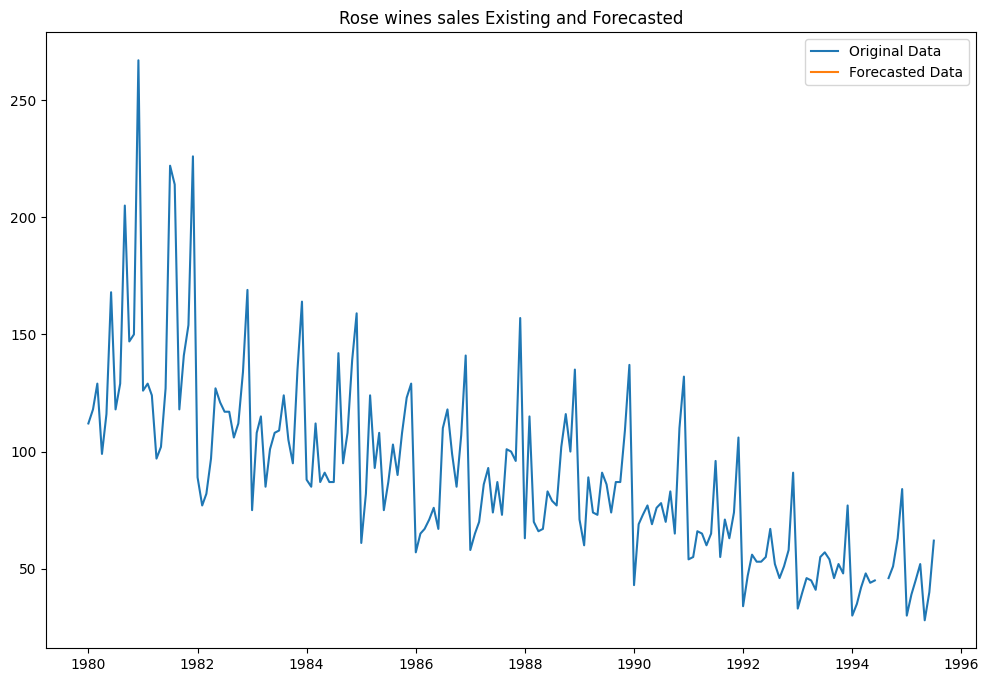

In [193]:
# model_TES = '______________'('______________________') # Complete the code to build the best model to forecast

# model_TES_alpha_i_j_k = model_TES.fit('____________________________') # Complete the code to fit the model

# predicted_results_final = model_TES_alpha_i_j_k.forecast(steps='___') # Complete the code to forecast for the next 12 months

plt.plot(df['Rose'], label = 'Original Data')
plt.plot(predicted_results_final, label = 'Forecasted Data')
plt.legend(loc ='best')
plt.title('Rose wines sales Existing and Forecasted');

# Business Recommendations & Insights

•	The 2-point Trailing Moving Average model is the most accurate model based on the RMSE value and should be preferred for forecasting or predictions on this dataset.

•	Introduce promotional discounts and bundled offers during high-demand seasons to maximize revenue and attract more customers.

•	Explore new wine variants or complementary products to capitalize on existing trends and cater to evolving consumer preferences.

•	Utilize the observed seasonal patterns to design targeted marketing campaigns during peak sales months, such as holidays and festive seasons.


# Conclusion

The analysis of the Rose wine dataset reveals steady growth in sales with moderate seasonal variations. While the sales patterns are less volatile than Sparkling wine, they still exhibit periodic trends that may be linked to seasonal preferences or marketing campaigns. The decomposition analysis highlights a stable trend component, suggesting consistent demand over time. Forecasting models indicate gradual growth, providing opportunities for sustained marketing efforts and inventory planning. Recommendations include focusing on targeted promotions to boost sales during identified seasonal peaks, optimizing distribution channels to maintain steady supply, and leveraging data analytics to identify emerging market trends for further expansion.